This notebook is following up on `OTUnbalanced.ipynb` to try to solve the "zero-padding" problem. Namely, that real particles might be closer to fake particles than to other real particles.

In this notebook, we repeat `OTUnbalanced.ipynb` but now with normalized $pT$ (similar to the "3D; normalized pT" in `OT_PTMass.ipynb`) to make $\kappa$ behavior less arbitrary.

# Information about data

The data we are using was a part of the [ML4Jets 2021 data challenge](https://indico.cern.ch/event/980214/contributions/4413658/attachments/2278124/3870358/ml4jets_data_challenge.pdf). It is publically available in `.h5` format so it's great for doing some preliminary exploration!

**Publication:**

E. Govorkova, E. Puljak, T. Aarrestad, M. Pierini, K. A. Woźniak and J. Ngadiuba, LHC physics dataset for unsupervised New Physics detection at 40 MHz, Sci. Data 9, 118 (2022),
doi:[10.1038/s41597-022-01187-8](https://www.nature.com/articles/s41597-022-01187-8), arXiv:2107.02157

**Data:**

NOTE: The original data had several bugs in it. The links in the original materials (i.e. publication and slides) point to the incorrect Version 1 of the data. Version 2 should be used instead. [This website](https://mpp-hep.github.io/ADC2021/) contains the correct links/descriptions/usage information.

- `background_for_training.h5`: 4 million Standard Model (SM) background "training" data ([link to data](https://zenodo.org/record/5046428#.ZB9yKezMKHu))
-  `Ato4l_lepFilter_13TeV_filtered.h5`: # Neutral scalar boson events, $A \rightarrow 4l$, mass = $50$ GeV ([link to data](https://zenodo.org/record/7152590#.ZB9yROzMKHu))
- `leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5`: # Leptoquark events, ${\rm LQ} \rightarrow b \tau$ ([link to data](https://zenodo.org/record/7152599#.ZB9yZOzMKHu))
- `hToTauTau_13TeV_PU20_filtered.h5`: # Scalar boson events, $h^0 \rightarrow \tau \tau$ ([link to data](https://zenodo.org/record/7152614#.ZB9ybOzMKHt))
- `hChToTauNu_13TeV_PU20_filtered.h5`: # Charged scalar boson events, $h^\pm \rightarrow \tau \nu$ ([link to data](https://zenodo.org/record/7152617#.ZB9yf-zMKHt))
- `BlackBox_background_mix.h5`: # Mystery events ([link to data](https://zenodo.org/record/5072068#.ZB9yk-zMKHt))

In [1]:
sigAliasList    = ['sig_A', 'sig_h0', 'sig_hch', 'sig_LQ']
sigFilenameList = ['Ato4l_lepFilter_13TeV_filtered.h5', 'hToTauTau_13TeV_PU20_filtered.h5', 'hChToTauNu_13TeV_PU20_filtered.h5', 'leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5']

# Import libraries

We'll eventually be using the PyOT library to compute Wasserstein distances for now (see [here](https://pythonot.github.io/index.html)).

In [2]:
!pip install POT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 18.5 MB/s eta 0:00:00


In [3]:
import numpy as np
from numpy.random import RandomState
import numpy.ma as ma

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

import h5py
import ot
from numpy.random import Generator, PCG64
from sklearn import metrics
import itertools

# Functions

## Data handling functions

In [4]:
def calcGroundCostMatrix(xs, xt, MODE='Normal'):
  """
  Calculate ground cost matrix between xs and xt

  Inputs:
     xs:  3D coordinates of nx source particles (shape=(nx,3));
          nx = number of non-zero entries in xEvents
     xt:  3D coordinates of ny source particles (shape=(ny,3));
          ny = number of non-zero entries in yEvents

  Output:
     If MODE=='Normal', returns matrix of pair-wise |x - y|^2 distances.
     If MODE=='Modular', it assumes that the last coordinate of the 3 is \phi
     which is modular and takes this into account when computing the matrix of
     pair-wise |x - y|^2 distances

  """
  if MODE=='Normal':
    return ot.dist(xs, xt)
  elif MODE=='Modular':
    #! Faster way?
    # Modified from Tianji's code
    #   d_phis = np.pi - np.abs(np.pi - np.abs(jet1_coords[:,1,None]-jet2_coords[:,1]))
    #   squareDist = (jet1_coords[:,0,None]-jet2_coords[:,0])**2 + d_phis**2

    # Note according to this thread, this way of calculating modular differences may fail if deltaPhi_raw > 360 deg (2 pi)
    # However, since the input is between -pi and pi, the max possible is 2pi so it shouldn't be a problem
    # https://stackoverflow.com/questions/1878907/how-can-i-find-the-smallest-difference-between-two-angles-around-a-point
    # It is also unsigned, however since we will square it that doesn't matter

    deltaPT      = xs[:,0,None] - xt[:,0]
    deltaEta     = xs[:,1,None] - xt[:,1]
    deltaPhi_raw = xs[:,2,None] - xt[:,2]
    deltaPhi     = np.pi - np.abs(np.pi - np.abs(deltaPhi_raw))
    return deltaPT**2 + deltaEta**2 + deltaPhi**2
  else: # Test mode
    deltaPT      = xs[:,0,None] - xt[:,0]
    deltaEta     = xs[:,1,None] - xt[:,1]
    deltaPhi_raw = xs[:,2,None] - xt[:,2]
    return deltaPT**2 + deltaEta**2 + deltaPhi_raw**2

In [5]:
#!
def calcOTGeneral(xEvents, yEvents, div='l2', reg_m = 1.):
  """
  Solve the optimal transport problem for a set of source events (xEvents) and
  target events (yEvents) assuming |x - y|^2 is the ground cost function.

  Inputs:
     xEvents:  Array of sample of x-type events, shape (N, 19, 3)
     yEvents:  Array of sample of y-type events, shape (N, 19, 3)

  Outputs
     CXY:  List of length N**2 the X-to-Y OT cost matrices, each of shape (nx, ny)
           nx(ny) = number of non-zero entries in xEvents(yEvents)
     wXY:  Array of the corresponding Wasserstein distances

  NOTE: We're using the following references:
  - https://pythonot.github.io/auto_examples/plot_OT_2D_samples.html#sphx-glr-auto-examples-plot-ot-2d-samples-py
  - https://pythonot.github.io/quickstart.html#solving-optimal-transport
  """

  # Create lists for outputs
  CXY, wXY = [], []

  # Get number of signal and background events
  #! Make more general later to handle different number of x and y events
  assert(xEvents.shape[0] == yEvents.shape[0])
  N = xEvents.shape[0]



  # # Assume that all "particles" are equally weighted
  # #! In the example "n" was number of samples... is this adaptation ok?
  # # https://pythonot.github.io/all.html#ot.emd
  # nParticles = xEvents.shape[1] #19
  # a = np.ones((nParticles,)) / nParticles
  # b = a

  #-- Loop over pairs of events --#
  # We use itertools to make looping more efficient (i.e. do double for loops)
  dummyArr = np.arange(N)
  for (i,j) in itertools.product(dummyArr, dummyArr):

    # Get source and target data points; Remove 0 padding
    sMask = ~np.all(xEvents[i, :, :] == 0., axis=1)
    tMask = ~np.all(yEvents[j, :, :] == 0., axis=1)

    xs = xEvents[i, :, :][sMask] # "source data points"
    xt = yEvents[j, :, :][tMask] # "target data points"

    # Normalize pT information
    totPTs, totPTt = xs[:,0].sum(), xt[:,0].sum()
    xs[:,0], xt[:,0] = xs[:,0]/totPTs, xt[:,0]/totPTt

    # Get unnormalized masses
    nx, ny = xs.shape[0], xt.shape[0]
    a = np.ones((nx,))
    b = np.ones((ny,))


    #-- Solve X-Y OT problem  --#

    # Calculate XY cost matrix
    cxy = calcGroundCostMatrix(xs, xt, MODE='Modular')
    CXY.append(cxy)

    # Calculate the unbalanced Wasserstein distance (#! using default settings!)
    # https://pythonot.github.io/gen_modules/ot.unbalanced.html#id38
    # print(xs.shape, xt.shape, nx, ny, a.shape, b.shape, cxy.shape)
    wXY.append(ot.unbalanced.mm_unbalanced2(a, b, cxy, reg_m, div))

  return CXY, np.array(wXY)

In [6]:
def randomDataSample(data, nEvents, random_state):
  """
  Generate a random sample of data by generating a 1D array of nEvents uniform
  random integers and returning the events corresponding to these integers.

  Inputs:
    data:          Total data array of shape (nTotal, 19, 3)
    nEvents:       Number of events to sample
    random_state:  The generator to use to generate the samples (for reproducibility)

  Outputs:
    Selected events; shape (nEvents, 19, 3)
  """
  #! Pretty slow in practice (not sure why), make it faster later

  nTotal = data.shape[0]
  randomIntArray = random_state.integers(0,nTotal,nEvents)

  return data[randomIntArray, :, :]

In [7]:
def calcAUC(scoreBkg, scoreSig):
  """
  Given the anomaly scores for background and signal events, calculate the AUC.

  Inputs:
    scoreBkg:   Anomaly score values for N background events; shape (N,)
    scoreSig:   Anomaly score values for M signal events; shape (M,)

  Outputs:
    auc:        Area Under the Curve (AUC) value; float
    labels:     Numeric background/signal labels; 0 for background, 1 for signal
                (necessary for ROC and AUC calculations); shape (N+M,)
    scores:     Concatenated anomaly scores from background and signal events;
                (necessary for ROC and AUC calculations); shape (N+M,)

  NOTE: Using the sklearn.metrics.roc_auc_score() function
  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
  """

  labelsB = np.repeat(0, scoreBkg.shape[0]) # Background labels
  labelsS = np.repeat(1, scoreSig.shape[0]) # Signal labels
  labels  = np.concatenate((labelsB, labelsS))

  scores  =  np.concatenate((scoreBkg, scoreSig))

  auc = metrics.roc_auc_score(labels, scores)

  return auc, labels, scores

In [8]:
def calcROCmetrics(scoreBkg, scoreSigList, SIreg=0.0001):
  """
  Calculate 4 metrics related to ROC curve components:
      - AUC
      - Background efficiency (aka FPR or eps_B), Signal efficiency (aka TPR or eps_S)
      - Significance Improvement (SI) defined as eps_S/sqrt(eps_B + SIreg) <=> TPR/sqrt(FPR + SIreg)
        where SIreg is a regulator for statistical fluctuations at low efficiency; SIreg=0.01% by default
        Reference: https://arxiv.org/pdf/2001.05001.pdf
      - Inverse Background efficiency (aka FPR^{-1} or eps_B^{-1}); division by zero is masked

  Inputs:
    scoreBkg:      Anomaly score values for N background events; shape (N,)
    scoreSigList:  List of anomaly score values for each signal type case; Length=nCases
                   scoreSigList[i] is the anomaly score for M signal events of the ith signal type case; shape (M,)
    SIreg:         Regulator to prevent division by zero when calculating SI metric; default 0.01%

  Outputs:
    aucList:       List of AUC scores for each background to signal type pairing; Length=nCases
    fprList:       List of FPR arrays for each background to signal type pairing; Length=nCases
                   fprList[i] is an array of shape (Q,) with Q>2
    tprList:       List of TPR arrays for each background to signal type pairing; Length=nCases
                   tprList[i] is an array of shape (Q,) with Q>2
    SIList:        List of SI arrays for each background to signal type pairing; Length=nCases
                   SIList[i] is an array of shape (Q,) with Q>2
    fprInvList:    List of inverse FPR arrays for each background to signal type pairing; Length=nCases
                   fprInvList[i] is a masked array of shape (Q,) with Q>2 with division by zero cases masked
  """

  #-- Preliminaries --#
  nCases    = len(scoreSigList) # Number of signal cases
  aucList, fprList, tprList, SIList, fprInvList = [], [], [], [], [] # Create lists to store results

  #-- Loop over signal cases --#
  for i in range(nCases):
    scoreSig = scoreSigList[i]

    #-- Calculate AUC (and, internally, label and score inputs for sklearn's function) --#
    auc, labels, scores = calcAUC(scoreBkg, scoreSig)
    aucList.append(auc)

    #-- Calculate other ROC curve metrics --#
    fpr, tpr, _ = metrics.roc_curve(labels, scores)
    fprList.append(fpr)
    tprList.append(tpr)

    #-- Calculate SI metric --#
    # Def: eps_S/sqrt(eps_B + SIreg) <=> TPR/sqrt(FPR + SIreg)
    fpr_sqrt = np.sqrt(fpr + SIreg)
    SI = tpr/fpr_sqrt
    SIList.append(SI)

    #-- Calculate inverse FPR metric --#
    #! Should we also use regulator here? Is this typical?
    fpr_masked = ma.masked_where(fpr==0., fpr) # Get rid of possibility of dividing by zero
    fprInv = 1./fpr_masked
    fprInvList.append(fprInv)

  return aucList, fprList, tprList, SIList, fprInvList

In [9]:
def indxOfCertainTPR(tprList, TPRval = 0.3):
  """
  For each TPR array in tprList, get the index corresponding to the TPR value
  which is closest to TPRval. This can be used to examine the other metrics at
  a certain TPR (signal efficiency, \eps_S) value.

  Inputs:
    tprList:   List of TPR arrays for each background to signal type pairing; Length=number of signal cases
               tprList[i] is an array of shape (Q,) with Q>2
    TPRval:    Fixed reference TPR value; default is TPR = \eps_S = 30%

  Outputs:
    indxList:  List of indices corresponding to TPR ~= TPRval; length = number of signal cases
  """
  indxList = []
  nCases = len(tprList) # Number of signal cases

  for i in range(nCases):
    tprArr = tprList[i]
    difference_array = np.absolute(tprArr-TPRval)
    indx = difference_array.argmin()
    indxList.append(indx)

  return indxList

In [10]:
def calcIndividualOTScores(trimmedDataDict, sigAliasList, speciesList=['MET', 'e', 'mu', 'jet']):
  """
  Calculate individual OT scores and store them in a score dictionary.

  Inputs:
    trimmedDataDict:  Dictionary of data trimmed to size (N, 19, 3); contains
                      two samples of background data ('bkgEvents1' and 'bkgEvents2')
                      and one sample of signal data for each signal type ('sig_A',
                      'sig_h0', 'sig_hch', 'sig_LQ')
    sigAliasList:     List of signal type aliases; i.e. ['sig_A', 'sig_h0', 'sig_hch', 'sig_LQ']
    speciesList:      List of species; default ['MET', 'e', 'mu', 'jet']

  Outputs:
    scoreDict: Dictionary of scores for OT on each particle species
  """
  scoreDict = {}

  #-- Loop over particle species
  for species in speciesList:
    scoreDict[species] = {}

    #-- Set background data according to species type --#
    if species == 'MET':
      B1_data = trimmedDataDict['bkgEvents1'][:, 0, :].reshape(-1,1,3)
      B2_data = trimmedDataDict['bkgEvents2'][:, 0, :].reshape(-1,1,3)
    elif species == 'e':
      B1_data = trimmedDataDict['bkgEvents1'][:, 1:5, :]
      B2_data = trimmedDataDict['bkgEvents2'][:, 1:5, :]
    elif species == 'mu':
      B1_data = trimmedDataDict['bkgEvents1'][:, 5:9, :]
      B2_data = trimmedDataDict['bkgEvents2'][:, 5:9, :]
    elif species == 'jet':
      B1_data = trimmedDataDict['bkgEvents1'][:, 9:, :]
      B2_data = trimmedDataDict['bkgEvents2'][:, 9:, :]

    #-- Calculate OT distance for background-to-background case --#
    _, scoreDict[species]['wBB'] = calcOTGeneral(B1_data, B2_data)

    #-- Loop over signal cases to calculate OT distance in background-to-signal case --#
    for alias in sigAliasList:

      #-- Set signal data according to species type --#
      if species == 'MET':
        S_data = trimmedDataDict[alias][:, 0, :].reshape(-1,1,3)
      elif species == 'e':
        S_data = trimmedDataDict[alias][:, 1:5, :]
      elif species == 'mu':
        S_data = trimmedDataDict[alias][:, 5:9, :]
      elif species == 'jet':
        S_data = trimmedDataDict[alias][:, 9:, :]

      #-- Calculate OT distance for background-to-signal case --#
      name_w = 'wBS_'+alias
      _, scoreDict[species][name_w] = calcOTGeneral(B1_data, S_data)

  return scoreDict

In [11]:
def calcWeightedComboOTscores(scoreDict, wList=[1., 1., 1., 1.]):
  """
  calculate a combination of individual species OT scores for each subkey case

  Inputs:
    scoreDict:  Dictionary of scores for OT on each particle species; e.g. scoreDict['MET']['wBB']
    wList:      How much to weight 'MET', 'e', 'mu', 'jet' information, respectively, in the sum;
                default equal weighting wList=[1., 1., 1., 1.]
  Outputs:
    Updated scoreDict
  """
  #-- Calculate and store combination (sum) --#
  scoreDict['combo'] = {}
  for subkey in scoreDict['MET'].keys():
    nameCombo = 'combo_'+str(subkey)
    scoreDict['combo'][nameCombo]  = wList[0]*scoreDict['MET'][subkey] + wList[1]*scoreDict['e'][subkey] + wList[2]*scoreDict['mu'][subkey] + wList[3]*scoreDict['jet'][subkey]

  return scoreDict

In [12]:
def getFractionsOfMax(indxs, val):
  """
  Calculates the fraction of indxs entries that equal val
  """

  indxs_masked = ma.masked_where(indxs==val, indxs)
  total        = indxs.shape[0]
  fraction     = float(np.sum(indxs_masked.mask))/ float(total)

  return fraction

def maxIndividualOTScore(scoreDict, alias):
  """
  Calculates which individual OT score is the largest for each event in signal type alias
  """

  # Get individual OT scores from dictionary
  metArr = scoreDict['MET'][alias].reshape(-1, 1)
  eArr   = scoreDict['e'][alias].reshape(-1, 1)
  muArr  = scoreDict['mu'][alias].reshape(-1, 1)
  jetArr = scoreDict['jet'][alias].reshape(-1, 1)

  comboArr = np.concatenate((metArr, eArr, muArr, jetArr), axis=1)

  # Get index of max individual OT score for each event
  # 0=met, 1=e, 2=mu, 3=jet
  indxs  = np.argmax(comboArr, axis=1)
  maxArr = np.max(comboArr, axis=1)

  # Print fractions
  print("Signal Type = ", alias)
  print("Fraction of times that each individual OT score was the maximum for a given event:")
  print("   MET: %s "%str(getFractionsOfMax(indxs, 0)*100))
  print("     e: %s "%str(getFractionsOfMax(indxs, 1)*100))
  print("    mu: %s "%str(getFractionsOfMax(indxs, 2)*100))
  print("   jet: %s "%str(getFractionsOfMax(indxs, 3)*100))

  return indxs, maxArr

In [13]:
def calcMultiplicityData(objectsBkg, objectsSigList):
  """
  Inputs:
    objectsBkg:       pT of all objects for each background event; ndarray of shape
                      (Nb, 19) where Nb is the number of background events
    objectsSigList:   List of arrays of pT of all objects for each signal event;
                      element of list is ndarray of shape (Ns, 19), where Ns, the
                      number of signal events, varies depending on the signal type;
                      signal types in list is 'sig_A', 'sig_h0', 'sig_hch', 'sig_LQ'
  Outputs:
    multBkgList:      List of arrays corresponding to electron, muon, jet, and total multiplicities
    multSigList:      List of list of arrays corresponding to electron, muon, jet, and total multiplicities for each signal type
                      E.g. multSigList[0] is the list of electron multiplicities for all signal types
                      Total multiplicity is defined as multiplicity of all particle-type objects (i.e. excluding MET which is always present)
  """

  #-- Get multiplicities for background data --#
  multElectrons_Bkg = np.count_nonzero(objectsBkg[:, 1:5], axis=1)
  multMuons_Bkg     = np.count_nonzero(objectsBkg[:, 5:9], axis=1)
  multJets_Bkg      = np.count_nonzero(objectsBkg[:, 9:19], axis=1)
  multTotal_Bkg     = np.count_nonzero(objectsBkg[:, 1:19], axis=1) # Exclude MET since it is always present

  multBkgList = [multElectrons_Bkg, multMuons_Bkg, multJets_Bkg, multTotal_Bkg]

  #-- Get multiplicities for signal data --#
  listMultElectrons_Sig, listMultMuons_Sig, listMultJets_Sig, listMultTotal_Sig = [],[],[],[]
  nSignalCategories = len(objectsSigList)
  for i in range(nSignalCategories):
    objectsSig = objectsSigList[i]

    listMultElectrons_Sig.append(np.count_nonzero(objectsSig[:, 1:5], axis=1))
    listMultMuons_Sig.append(np.count_nonzero(objectsSig[:, 5:9], axis=1))
    listMultJets_Sig.append(np.count_nonzero(objectsSig[:, 9:19], axis=1))
    listMultTotal_Sig.append(np.count_nonzero(objectsSig[:, 1:19], axis=1))

  multSigList = [listMultElectrons_Sig, listMultMuons_Sig, listMultJets_Sig, listMultTotal_Sig]

  return multBkgList, multSigList

## Plotting functions

In [14]:
def RGBAtoRGBAtuple(color, TYPE='tuple'):
  """
  Quick function to convert human RGBA to python RGBA tuple format. Example:
     Human RGBA  = (120,15,116,1)
     Python RGBA = RGBAtoRGBAtuple((120,15,116,1))

  Inputs:
    color:   Human RGBA tuple
    TYPE:    Flag to indicate whether you want function to return a list or tuple; default is tuple
  Outputs:
    Python RGBA tuple (or list)
  """
  r = color[0]/255
  g = color[1]/255
  b = color[2]/255
  a = color[3]

  if TYPE=='list':
    return [r, g, b, a]
  else:
    return (r, g, b, a)

In [15]:
def plotDataHists(objectBkg, objectSigList, plotArgDict):
  """
  Plot histograms of an object's pT, eta, phi for Signal and Signal+Background
  for each signal case.

  Inputs:
    objectBkg:      A background event's object's (e.g. MET) pT, eta, phi;
                    shape = (Nb, 3); Nb = number of background events
    objectSigList:  A list of signal event object's (e.g. MET) pT, eta, phi for
                    nCases number of signal cases; List of tuples with shapes
                    (Ns, 3); Ns = number of signal events
    plotArgDict:    Dictionary of plotting arguments (see example below)

  Outputs:
    Nothing returned; Show plot


  Example plotArgDict:
  # Define colors to use for 4 signal types
      SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                                  ])
  # Or use a matplotlib color map
      SIGNAL_COLOR_ARR = plt.colormaps['rainbow'].reversed()

  # Then define dictionary as follows
      plotArgDict = {}
      plotArgDict['pltDim']             = (1,3) # i.e. 1 row, 3 columns
      plotArgDict['xAxisLimsList']      = [(0, 1500), (-5, 5), (-np.pi, np.pi)]
      plotArgDict['title']              = r'MET'
      plotArgDict['nBins']              = 50
      plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
      plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']
  """

  #-- Preliminary Figure Setup --#
  pltDim = plotArgDict['pltDim']
  fig_size = (7*pltDim[1], 7*pltDim[0])
  fig = plt.figure(constrained_layout=True, figsize=fig_size)
  gs = GridSpec(pltDim[0], pltDim[1], figure=fig, hspace=0.1)
  axes = []
  for i in range(pltDim[1]):
    axes.append(fig.add_subplot(gs[:, i]))

  xLabelList = [r'$p_{\rm T}$', r'$\eta$', r'$\phi$']

  #-- Define color map --#
  # Reference: https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap
  nCases    = len(objectSigList)  # Number of cases to plot
  if isinstance(plotArgDict['CMAP'], np.ndarray) and (plotArgDict['CMAP'].shape[0]==nCases):
    colorList = plotArgDict['CMAP']
  else:
    CMAP      = plotArgDict['CMAP']
    colorList = CMAP(np.linspace(0,1,nCases))

  #-- Combine data for S+B plots for all signal types --#
  objectBkgSigList = []
  for objectSig in objectSigList:
    objectBkgSigList.append(np.concatenate((objectBkg, objectSig), axis=0))


  #-- Loop over axes to make plots --#
  for i in range(pltDim[1]):

    ax = axes[i]

    # Set axis and title information
    xmin, xmax = plotArgDict['xAxisLimsList'][i]
    ax.set_xlim(xmin, xmax)
    ax.set(xlabel=xLabelList[i])
    ax.xaxis.label.set_size(16)

    if i==0:
      ax.set(ylabel=r'Simulated events')
      ax.yaxis.label.set_size(16)

    if i==1:
      ax.set_title(plotArgDict['title'], fontsize=20)

    # Set bin information
    bins = np.linspace(xmin, xmax, plotArgDict['nBins'])

    #-- Plot background case --#
    _, _, _,   = ax.hist(objectBkg[:,i], bins=bins, histtype = 'step', edgecolor='black', linestyle='-', linewidth=2, fill=False, log=True, label='Background')

    #-- Loop over signal cases --#
    for j in range(nCases):
      objectBkgSig = objectBkgSigList[j]
      objectSig    = objectSigList[j]

      # Get data
      SB = objectBkgSig[:,i]
      S  = objectSig[:,i]

      # Make plot
      Slabel = plotArgDict['sigObjectNameList'][j]+' Signal'
      SBlabel = Slabel+' + Background'
      _, _, _,   = ax.hist(SB, bins=bins, histtype = 'step', edgecolor=colorList[j], linestyle='--', linewidth=2, fill=False, log=True, label=SBlabel)
      #_, _, _,   = ax.hist(S, bins=bins, color=colorList[j], alpha=0.1, log=True, label=Slabel)

    if i==0:
      ax.legend(loc='upper right')

  #-- Show the plot --#
  plt.show()

In [16]:
def plotScoreHists(scoreBkg, scoreSigList, plotArgDict):
  """
  Plot a 1D histogram of the anomaly score for the background and each signal case

  Inputs:
    scoreBkg:      An array of anomaly scores for a set of background events;
                   shape = (Nb, ); Nb = number of background events
    scoreSigList:  A list of arrays of anomaly scores for nCases number of signal cases;
                   List of length nCases of arrays with shapes (Ns, 3);
                   Ns = number of signal events
    plotArgDict:    Dictionary of plotting arguments (see example below)

  Outputs:
    Nothing returned; Show plot

  Example plotArgDict:
  # Define colors to use for 4 signal types
      SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                                  ])
  # Or use a matplotlib color map
      SIGNAL_COLOR_ARR = plt.colormaps['rainbow'].reversed()

  # Then define dictionary as follows
  plotArgDict = {}
  plotArgDict['pltDim']             = (3,3)
  plotArgDict['xAxisLims']          = (0, 17500)
  plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
  plotArgDict['yAxisLims']          = (1, 1e4)
  plotArgDict['yLabel']             = r'Counts'
  plotArgDict['title']              = r''
  plotArgDict['nBins']              = 100
  plotArgDict['logY']               = True
  plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
  plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']
  """

  #-- Preliminary Figure Setup --#
  pltDim = plotArgDict['pltDim']
  fig_size = (3*pltDim[1], 3*pltDim[0])

  fig = plt.figure(constrained_layout=False, figsize=fig_size)

  gs = GridSpec(pltDim[0], pltDim[1], figure=fig, hspace=0.1)
  ax = fig.add_subplot(gs[:, :])

  xmin, xmax = plotArgDict['xAxisLims']
  ax.set_xlim(xmin, xmax)
  ax.set(xlabel=plotArgDict['xLabel'])
  ax.xaxis.label.set_size(16)

  ymin, ymax = plotArgDict['yAxisLims']
  ax.set_ylim(ymin, ymax)
  ax.set(ylabel=plotArgDict['yLabel'])
  ax.yaxis.label.set_size(16)

  ax.set_title(plotArgDict['title'], fontsize=20)

  if 'density' in  list(plotArgDict.keys()):
    DENSITY = plotArgDict['density']
  else:
    DENSITY = False

  #-- Define color map --#
  # https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap
  nCases    = len(scoreSigList)  # Number of cases to plot
  if isinstance(plotArgDict['CMAP'], np.ndarray) and (plotArgDict['CMAP'].shape[0]==nCases):
    colorList = plotArgDict['CMAP']
  else:
    CMAP      = plotArgDict['CMAP']
    colorList = CMAP(np.linspace(0,1,nCases))

  #-- Make histogram plot --#
  binsArr = np.linspace(xmin, xmax, plotArgDict['nBins'])
  _, _, _   = ax.hist(scoreBkg, bins=binsArr, histtype = 'step', edgecolor='black', linestyle='-', linewidth=2, fill=False, log=True, label='Background', density=DENSITY)

  for i in range(nCases):
    label = plotArgDict['sigObjectNameList'][i]
    _, _, _,   = ax.hist(scoreSigList[i], bins=binsArr, histtype = 'step', edgecolor=colorList[i], linestyle='--', linewidth=2, fill=False, log=True, label=label, density=DENSITY)

  #-- Show the plot with legend --#
  ax.legend()
  plt.show()

In [17]:
def plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Classic'):
  """
  Plot ROC curves from values precalculated using the calcROCmetrics() function.

  Inputs:
    aucList:      List of AUC scores for each background to signal type pairing; Length=nCases
    fprList:      List of FPR arrays for each background to signal type pairing; Length=nCases
                  fprList[i] is an array of shape (Q,) with Q>2
    tprList:      List of TPR arrays for each background to signal type pairing; Length=nCases
                  tprList[i] is an array of shape (Q,) with Q>2
    plotArgDict:  Dictionary of plotting arguments (see example below)
    TYPE:         TYPE of ROC curve to plot; choices are 'Classic' (default) or 'Modern'
                  (see below for explanation)


  Explanation of TYPE choices:
    For all TYPE choices the x-axis is defined as the Signal (Acceptance)
    Efficiency <=> TPR <=> \eps_S

    if TYPE == 'Classic':
        y-axis is the Background Rejection Efficiency <=> TNR <=> 1 - FPR <=> 1 - \eps_B
    otherwise:
        y-axis is the Background (Acceptance) Efficiency <=> FPR <=> \eps_B


  Example plotArgDict:
  # Define colors to use for 4 signal types
      SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                                  ])
  # Or use a matplotlib color map
      SIGNAL_COLOR_ARR = plt.colormaps['rainbow'].reversed()

  # Then define dictionary as follows (assuming TYPE == 'Classic')
      plotArgDict = {}
      plotArgDict['pltDim']    = (3,3)
      plotArgDict['xAxisLims'] = (0, 1.05)
      plotArgDict['xLabel']    = r'Signal Efficiency (TPR)' # OR r'$\eps_S$'
      plotArgDict['yAxisLims'] = (0, 1.05)
      plotArgDict['yLabel']    = r'Background Rejection (TNR)' # OR r'$1 - \eps_B$'
      plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
      plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
      plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']
  """

  #-- Preliminary Figure Setup --#
  pltDim = plotArgDict['pltDim']
  fig_size = (3*pltDim[1], 3*pltDim[0])

  fig = plt.figure(constrained_layout=False, figsize=fig_size)

  gs = GridSpec(pltDim[0], pltDim[1], figure=fig, hspace=0.1)
  ax = fig.add_subplot(gs[:, :])

  xmin, xmax = plotArgDict['xAxisLims']
  ax.set_xlim(xmin, xmax)
  ax.set(xlabel=plotArgDict['xLabel'])
  ax.xaxis.label.set_size(16)

  ymin, ymax = plotArgDict['yAxisLims']
  ax.set_ylim(ymin, ymax)
  ax.set(ylabel=plotArgDict['yLabel'])
  ax.yaxis.label.set_size(16)

  ax.set_title(plotArgDict['title'], fontsize=20)

  #-- Define color map --#
  # https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap
  nCases    = len(scoreSigList)  # Number of cases to plot
  if isinstance(plotArgDict['CMAP'], np.ndarray) and (plotArgDict['CMAP'].shape[0]==nCases):
    colorList = plotArgDict['CMAP']
  else:
    CMAP      = plotArgDict['CMAP']
    colorList = CMAP(np.linspace(0,1,nCases))

  #-- Loop over signal cases --#
  for i in range(nCases):

    #-- Get ROC curve components --#
    auc, fpr, tpr = aucList[i], fprList[i], tprList[i]

    #-- Plot ROC curve --#
    legendLabel = plotArgDict['sigObjectNameList'][i]+': AUC='+str(auc)
    if TYPE == 'Classic':
      tnr = 1. - fpr
      _   = ax.plot(tpr, tnr, color=colorList[i], linestyle='-', linewidth=2, label=legendLabel)
    else:
      _   = ax.plot(tpr, fpr, color=colorList[i], linestyle='-', linewidth=2, label=legendLabel)

  #-- Show the plot with legend --#
  if TYPE == 'Classic':
    ax.legend(loc='lower left')
  else:
    ax.legend(loc='upper left')
  plt.show()

In [18]:
def plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict):
  """
  Plot FPR inverse curves from values precalculated using the calcROCmetrics() function.

    x-axis is the Signal (Acceptance) Efficiency <=> TPR <=> \eps_S
    y-axis is the inverted the Background (Acceptance) Efficiency <=> FPR <=> \eps_B

  NOTE: This is often also called a "ROC curve" however this is misleading because
  the AUC is NOT the area under this curve, so it is NOT a ROC curve.

  Inputs:
    aucList:      List of AUC scores for each background to signal type pairing; Length=nCases
    fprInvList:   List of inverse FPR arrays for each background to signal type pairing; Length=nCases
                  fprInvList[i] is a masked array of shape (Q,) with Q>2 with division by zero cases masked
    tprList:      List of TPR arrays for each background to signal type pairing; Length=nCases
                  tprList[i] is an array of shape (Q,) with Q>2
    plotArgDict:  Dictionary of plotting arguments (see example below)


  Example plotArgDict:
  # Define colors to use for 4 signal types
      SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                                  ])
  # Or use a matplotlib color map
      SIGNAL_COLOR_ARR = plt.colormaps['rainbow'].reversed()

  # Then define dictionary as follows
      plotArgDict = {}
      plotArgDict['pltDim']    = (3,3)
      plotArgDict['xAxisLims'] = (0, 1.05)
      plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
      plotArgDict['yAxisLims'] = (1, 1e4)
      plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
      plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
      plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
      plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']
  """

  #-- Preliminary Figure Setup --#
  pltDim = plotArgDict['pltDim']
  fig_size = (3*pltDim[1], 3*pltDim[0])

  fig = plt.figure(constrained_layout=False, figsize=fig_size)

  gs = GridSpec(pltDim[0], pltDim[1], figure=fig, hspace=0.1)
  ax = fig.add_subplot(gs[:, :])

  xmin, xmax = plotArgDict['xAxisLims']
  ax.set_xlim(xmin, xmax)
  ax.set(xlabel=plotArgDict['xLabel'])
  ax.xaxis.label.set_size(16)

  ymin, ymax = plotArgDict['yAxisLims']
  ax.set_ylim(ymin, ymax)
  ax.set_yscale('log')
  ax.set(ylabel=plotArgDict['yLabel'])
  ax.yaxis.label.set_size(16)

  ax.set_title(plotArgDict['title'], fontsize=20)

  #-- Define color map --#
  nCases    = len(scoreSigList)  # Number of cases to plot
  if isinstance(plotArgDict['CMAP'], np.ndarray) and (plotArgDict['CMAP'].shape[0]==nCases):
    colorList = plotArgDict['CMAP']
  else:
    CMAP      = plotArgDict['CMAP']
    colorList = CMAP(np.linspace(0,1,nCases)) # https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap

  #-- Loop over signal cases --#
  for i in range(nCases):

    #-- Get ROC curve components --#
    auc, fprInv, tpr = aucList[i], fprInvList[i], tprList[i]

    #-- Plot ROC curve --#
    legendLabel = plotArgDict['sigObjectNameList'][i]+': AUC='+str(auc)
    _ = ax.plot(tpr, fprInv, color=colorList[i], linestyle='-', linewidth=2, label=legendLabel)

  #-- Show the plot with legend --#
  ax.legend(loc='upper right')
  plt.show()

In [19]:
def plotSIcurve(tprList, SIList, plotArgDict):
  """
   Plot the (regulated) Significance Improvement (SI) curve from values
   precalculated using the calcROCmetrics() function.

      x-axis is the Signal (Acceptance) Efficiency <=> TPR <=> \eps_S
      y-axis is the (regulated) Significance Improvement <=> SI := TPR/sqrt(FPR + SIreg) <=> SI := eps_S/sqrt(eps_B + SIreg)

  Inputs:
    tprList:      List of TPR arrays for each background to signal type pairing; Length=nCases
                  tprList[i] is an array of shape (Q,) with Q>2
    SIList:       List of SI arrays for each background to signal type pairing; Length=nCases
                  SIList[i] is an array of shape (Q,) with Q>2
    plotArgDict:  Dictionary of plotting arguments (see example below)


  Example plotArgDict:
  # Define colors to use for 4 signal types
      SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                                  ])
  # Or use a matplotlib color map
      SIGNAL_COLOR_ARR = plt.colormaps['rainbow'].reversed()

  # Then define dictionary as follows
    plotArgDict = {}
    plotArgDict['pltDim']    = (3,3)
    plotArgDict['xAxisLims'] = (0, 1.05)
    plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
    plotArgDict['yAxisLims'] = (0, 10)
    plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B}$ (SI)'
    plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
    plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
    plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']
  """

  #-- Preliminary Figure Setup --#
  pltDim = plotArgDict['pltDim']
  fig_size = (3*pltDim[1], 3*pltDim[0])

  fig = plt.figure(constrained_layout=False, figsize=fig_size)

  gs = GridSpec(pltDim[0], pltDim[1], figure=fig, hspace=0.1)
  ax = fig.add_subplot(gs[:, :])

  xmin, xmax = plotArgDict['xAxisLims']
  ax.set_xlim(xmin, xmax)
  ax.set(xlabel=plotArgDict['xLabel'])
  ax.xaxis.label.set_size(16)

  ymin, ymax = plotArgDict['yAxisLims']
  ax.set_ylim(ymin, ymax)
  ax.set(ylabel=plotArgDict['yLabel'])
  ax.yaxis.label.set_size(16)

  ax.set_title(plotArgDict['title'], fontsize=20)

  #-- Define color map --#
  # https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap
  nCases    = len(scoreSigList)  # Number of cases to plot
  if isinstance(plotArgDict['CMAP'], np.ndarray) and (plotArgDict['CMAP'].shape[0]==nCases):
    colorList = plotArgDict['CMAP']
  else:
    CMAP      = plotArgDict['CMAP']
    colorList = CMAP(np.linspace(0,1,nCases))

  #-- Loop over signal cases --#
  for i in range(nCases):

    #-- Get ROC curve components --#
    si, tpr = SIList[i], tprList[i]

    #-- Plot ROC curve --#
    legendLabel = plotArgDict['sigObjectNameList'][i]
    _ = ax.plot(tpr, si, color=colorList[i], linestyle='-', linewidth=2, label=legendLabel)

  #-- Show the plot with legend --#
  ax.legend(loc='upper right')
  plt.show()

In [20]:
def plotMaxIndividualOTScoresPerEvent(indxs, maxArr, plotArgDict):
  """
  Plot the (regulated) Significance Improvement (SI) curve from values
  precalculated using the calcROCmetrics() function.

      x-axis is the Signal (Acceptance) Efficiency <=> TPR <=> \eps_S
      y-axis is the (regulated) Significance Improvement <=> SI := TPR/sqrt(FPR + SIreg) <=> SI := eps_S/sqrt(eps_B + SIreg)

  Inputs:
    tprList:      List of TPR arrays for each background to signal type pairing; Length=nCases
                  tprList[i] is an array of shape (Q,) with Q>2
    SIList:       List of SI arrays for each background to signal type pairing; Length=nCases
                  SIList[i] is an array of shape (Q,) with Q>2
    plotArgDict:  Dictionary of plotting arguments (see example below)


  Example plotArgDict:
  # Define colors to use for 4 signal types
      SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                                  ])
  # Or use a matplotlib color map
      SIGNAL_COLOR_ARR = plt.colormaps['rainbow'].reversed()

  # Then define dictionary as follows
    plotArgDict = {}
    plotArgDict['pltDim']    = (3,3)
    plotArgDict['xAxisLims'] = (0, 1.05)
    plotArgDict['xLabel']    = r'Event Pairs'
    plotArgDict['yAxisLims'] = (0, 10)
    plotArgDict['yLabel']    = r'Max OT distance'
    plotArgDict['title']     = r'wBS_sig_A'
    plotArgDict['coreColorList'] = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
  """
  nEventPairs = maxArr.shape[0]

  #-- Preliminary Figure Setup --#
  pltDim = plotArgDict['pltDim']
  fig_size = (3*pltDim[1], 3*pltDim[0])

  fig = plt.figure(constrained_layout=False, figsize=fig_size)

  gs = GridSpec(pltDim[0], pltDim[1], figure=fig, hspace=0.1)
  ax = fig.add_subplot(gs[:, :])

  xmin, xmax = plotArgDict['xAxisLims']
  ax.set_xlim(xmin, xmax)
  ax.set(xlabel=plotArgDict['xLabel'])
  ax.xaxis.label.set_size(16)

  ymin, ymax = plotArgDict['yAxisLims']
  ax.set_ylim(ymin, ymax)
  ax.set(ylabel=plotArgDict['yLabel'])
  ax.yaxis.label.set_size(16)

  ax.set_title(plotArgDict['title'], fontsize=20)

  #-- Get color list for plotting --#
  coreColorList = plotArgDict['coreColorList']
  colorList     = []
  for i in range(maxArr.shape[0]):
    indx = indxs[i]
    colorList.append(coreColorList[indx])

  #-- Make plot --#
  eventPairsArr = np.arange(nEventPairs)
  ax.scatter(eventPairsArr, maxArr, color=colorList)

  #-- Plot key --#
  deltaY = (ymax - ymin)
  deltaX = (xmax - xmin)
  ax.text(xmin + 0.20*deltaX, ymin + 0.95*deltaY, r'IOT$_{\rm MET}$', color=coreColorList[0], fontsize=16, fontweight='bold')
  ax.text(xmin + 0.40*deltaX, ymin + 0.95*deltaY,   r'IOT$_{\rm e}$', color=coreColorList[1], fontsize=16, fontweight='bold')
  ax.text(xmin + 0.60*deltaX, ymin + 0.95*deltaY, r'IOT$_{\rm \mu}$', color=coreColorList[2], fontsize=16, fontweight='bold')
  ax.text(xmin + 0.80*deltaX, ymin + 0.95*deltaY, r'IOT$_{\rm jet}$', color=coreColorList[3], fontsize=16, fontweight='bold')

  #-- Show plot --#
  plt.show()

In [21]:
def plotMultiplicityData(multBkgList, multSigList, plotArgDict):
  """
  Plot histograms of the multiplicity of electrons, muons, and jets for Background and each Signal case.

  Inputs:
    multBkgList:      List of arrays corresponding to electron, muon, and jet multiplicities
                      E.g. multBkgList[0] is an array of shape (Nb,) where  Nb = number of background events
                      multBkgList[0][i] is the electron multiplicity for the ith event
    multSigList:      List of list of arrays corresponding to electron, muon, and jet multiplicities for each signal type
                      E.g. multSigList[0] is the list of electron multiplicities for all signal types
                      multSigList[0][j] is an array of shape (Ns,) where Ns = number of signal events in the jth signal type
                      multSigList[0][j][i] is the electron multiplicity for the ith event of signal type j
    plotArgDict:    Dictionary of plotting arguments (see example below)

  Outputs:
    Nothing returned; Show plot


  Example plotArgDict:
  # Define colors to use for 4 signal types
      SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                                  ])
  # Or use a matplotlib color map
      SIGNAL_COLOR_ARR = plt.colormaps['rainbow'].reversed()

  # Then define dictionary as follows
      plotArgDict = {}
      plotArgDict['pltDim']             = (1,3) # i.e. 1 row, 3 columns
      plotArgDict['xAxisLimsList']      = [(-0.5, 5.5), (-0.5, 5.5), (-0.5, 10.5)]
      plotArgDict['title']              = r'Multiplicity'
      plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
      plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']
  """

  #-- Preliminary Figure Setup --#
  pltDim = plotArgDict['pltDim']
  fig_size = (7*pltDim[1], 7*pltDim[0])
  fig = plt.figure(constrained_layout=True, figsize=fig_size)
  gs = GridSpec(pltDim[0], pltDim[1], figure=fig, hspace=0.1)
  axes = []
  for i in range(pltDim[1]):
    axes.append(fig.add_subplot(gs[:, i]))

  xLabelList = [r'$e$ multiplicity', r'$\mu$ multiplicity', r'${\rm jet}$ multiplicity']


  #-- Define color map --#
  # Reference: https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap
  nCases    = len(multSigList[0])  # Number of cases to plot
  if isinstance(plotArgDict['CMAP'], np.ndarray) and (plotArgDict['CMAP'].shape[0]==nCases):
    colorList = plotArgDict['CMAP']
  else:
    CMAP      = plotArgDict['CMAP']
    colorList = CMAP(np.linspace(0,1,nCases))


  #-- Loop over axes to make plots --#
  # i=0 => Electrons
  # i=1 => Muons
  # i=2 => Jets
  for i in range(pltDim[1]):
    ax = axes[i]

    # Set axis and title information
    xmin, xmax = plotArgDict['xAxisLimsList'][i]
    ax.set_xlim(xmin, xmax)
    ax.set(xlabel=xLabelList[i])
    ax.xaxis.label.set_size(16)

    if i==0:
      ax.set(ylabel=r'Percent of simulated events')
      ax.yaxis.label.set_size(16)

    if i==1:
      ax.set_title(plotArgDict['title'], fontsize=20)

    # Set bin information
    if i!=2:
      bins = np.linspace(0, 5, 6)-0.5
    else:
      bins = np.linspace(0, 11, 12)-0.5

    #-- Plot background case --#
    _, _, _,   = ax.hist(multBkgList[i], bins=bins, histtype = 'step', edgecolor='black', linestyle='-', linewidth=2, fill=False, log=True, label='Background', density=True)

    #-- Loop over signal cases --#
    for j in range(nCases):
      multSigList_ = multSigList[i]

      # Make plot
      Slabel = plotArgDict['sigObjectNameList'][j]+' Signal'
      _, _, _,   = ax.hist(multSigList_[j], bins=bins, histtype = 'step', edgecolor=colorList[j], linestyle='--', linewidth=2, fill=False, log=True, label=Slabel, density=True)

    if i==2:
      ax.legend(loc='upper right')

  #-- Show the plot --#
  plt.show()

# Data Exploration

## Google Drive preliminaries

In [22]:
#-- "Mount" Google Drive to access data and save files/images --#
# NOTE: If running locally, comment out this cell and change the basePath accordingly
# Reference: https://stackoverflow.com/questions/49031798/when-i-use-google-colaboratory-how-to-save-image-weights-in-my-google-drive
from google.colab import drive
drive.mount('/content/gdrive')

# You will be asked to sign into a Google account and give GoogleColab access

Mounted at /content/gdrive


In [23]:
# To check that mounting worked, uncomment and run the following. You should see the contents of the directory listed.
! ls '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/Data/'

Ato4l_lepFilter_13TeV_filtered.h5
background_for_training.h5
BlackBox_background_mix.h5
hChToTauNu_13TeV_PU20_filtered.h5
hToTauTau_13TeV_PU20_filtered.h5
leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5
OldBuggedDatasets


In [24]:
#-- Set base directory and data directory path --#
basePath   = '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/'
dataPath   = 'Data/'

bkgPath    = basePath+dataPath+'background_for_training.h5'
sigPathList = []
for x in sigFilenameList:
  sigPathList.append(basePath+dataPath+x)

## Load data

In [25]:
dataDict = {}
dataDict['bkg'] = h5py.File(bkgPath, 'r')

for i in range(len(sigAliasList)):
  alias   = sigAliasList[i]
  sigPath = sigPathList[i]
  dataDict[alias] = h5py.File(sigPath, 'r')

In [26]:
print("Background Keys in file (f_bkg := dataDict['bkg']):")
for key in dataDict['bkg'].keys():
  print("  ",key)
  print("      f_bkg[%s]"%key)
  print("           .shape: ", dataDict['bkg'][key].shape)
  print("           .dtype: ", dataDict['bkg'][key].dtype)

for alias in sigAliasList:
  print("")
  print("Signal Keys in file (f_sig := dataDict['%s']):"%alias)
  for key in dataDict[alias].keys():
    print("  ",key)
    print("      f_sig[%s]"%key)
    print("           .shape: ", dataDict[alias][key].shape)
    print("           .dtype: ", dataDict[alias][key].dtype)

Background Keys in file (f_bkg := dataDict['bkg']):
   Particles
      f_bkg[Particles]
           .shape:  (13451915, 19, 4)
           .dtype:  float64
   Particles_Classes
      f_bkg[Particles_Classes]
           .shape:  (4,)
           .dtype:  |S16
   Particles_Names
      f_bkg[Particles_Names]
           .shape:  (4,)
           .dtype:  |S5

Signal Keys in file (f_sig := dataDict['sig_A']):
   Particles
      f_sig[Particles]
           .shape:  (55969, 19, 4)
           .dtype:  float64
   Particles_Classes
      f_sig[Particles_Classes]
           .shape:  (4,)
           .dtype:  |S16
   Particles_Names
      f_sig[Particles_Names]
           .shape:  (4,)
           .dtype:  |S5

Signal Keys in file (f_sig := dataDict['sig_h0']):
   Particles
      f_sig[Particles]
           .shape:  (691283, 19, 4)
           .dtype:  float64
   Particles_Classes
      f_sig[Particles_Classes]
           .shape:  (388,)
           .dtype:  |S16
   Particles_Names
      f_sig[Particles_N

This indicates that there are 3 datasets in each file. The first dataset array is the actual data information (see table below).

Let the data be represented by $X$. The information for the $i^{\rm th}$ event is given by $X[i, :, :]$. This is the "face" of the 3D table below. The vertical axis on the "face" is 19 dimensional (${\rm MET}, (e/ \gamma)_i, \mu_j, {\rm jet}_k$ where $i, j = 1, ..., 4$ and $k=1, ..., 10$). The horizontal axis is 4 dimensional. It contains the $p_{\rm T}, \eta, \phi$ information as well as the class information (1, 2, 3 and 4 for MET, electron, muon and jet, respectively).

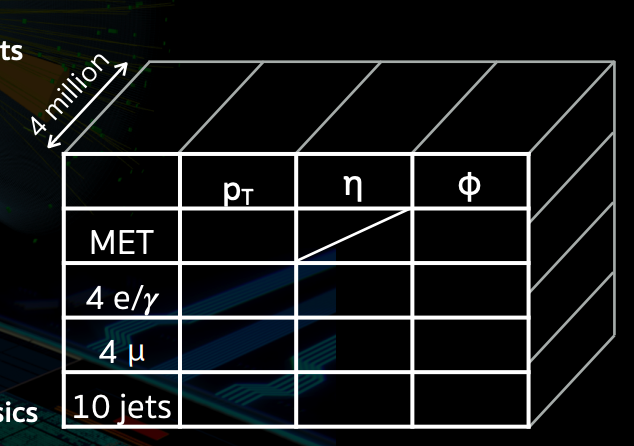

**Description from [the paper](https://www.nature.com/articles/s41597-022-01187-8)**:


*The data records are provided in Hierarchical Data Format version 5 (HDF5), and contain 3 datasets: “Particles”, “Particles_Classes” and “Particles_Names.*

*The dataset “Particles” has a shape (N, 19, 4), where N is the number of events listed for each sample in Table 1. The second index runs over the different physics objects in the events: MET, 4 electrons, 4 muons, 10 jets. Its cardinality (19) is the maximum number of objects per event. If fewer objects are present, the event is zero padded in such a way that the 1st, 5th, and 9th positions correspond to the highest-pT electron, muon, and jet, respectively.*

*The last index (with cardinality 4) runs over the three features describing each physics object and a particle type index, which is equal to 1, 2, 3 and 4 for MET, electron, muon and jet, respectively.*

*The information of which particle kind corresponds to which index value is contained in the “Particle_Classes” dataset, in the form of a single-entry array of strings. Zero padding is done inclusively, e.g. for zero-padded particles the particle type index is set to zero. The features are ordered as described in the “Particles_Names” dataset: pT, η, ϕ.*

*The blackbox sample includes an additional dataset (“EvtId”) with dimension (N), containing an event ID which allows us to match each event to its ground truth (signal or background)."*


$
\space
$

---

$
\space
$


Therefore, the event data we will use is has the shape (N, 19, 3). Where the $i^{th}$ event can be accessed via

```
EventData[i,:,:]
```
And will have shape (19,3). This event could be flattened to represent a point in 19*3 dimensional space. However, it's probably more natural to think of each event as being a collection of 19 particles living in 3D space. Note that events are zero-padded. So a non-existent particle lives at the origin in this 3D space.

In [27]:
print("Event 0 Raw data:")
print(dataDict['bkg']['Particles'][0, :, :])
print("")
print("Event 0 processed:")
print(dataDict['bkg']['Particles'][0, :, 0:3])
print("")
print("Event 0 particle labels:")
print(dataDict['bkg']['Particles'][0, :, -1])

Event 0 Raw data:
[[27.41296387  0.         -2.0499022   1.        ]
 [24.20996857  1.63350999 -0.10349621  2.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]

Event 0 pro

So background event 0 contains one MET, no electrons, one muon, and one jet.

In [28]:
print("Particles_Classes: ")
for i in range(4):
  print(dataDict['bkg']["Particles_Classes"][i])
print("")

print("Particles_Names: ")
for i in range(4):
  print(dataDict['bkg']["Particles_Names"][i])

Particles_Classes: 
b'MET_class_1'
b'Four_Ele_class_2'
b'Four_Mu_class_3'
b'Ten_Jet_class_4'

Particles_Names: 
b'Pt'
b'Eta'
b'Phi'
b'Class'


## Plot some axes of raw data

We'll plot the MET object's PT, eta, phi for all events for all signal types.

In [29]:
# Define colors to use for 4 signal types
SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                              RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                              RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                              RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                              ])

In [30]:
# Prepare object data for plotting
objectBkg = dataDict['bkg']['Particles'][:, 0, :]

objectSigList = []
for alias in sigAliasList:
  objectSigList.append(dataDict[alias]['Particles'][:, 0, :])

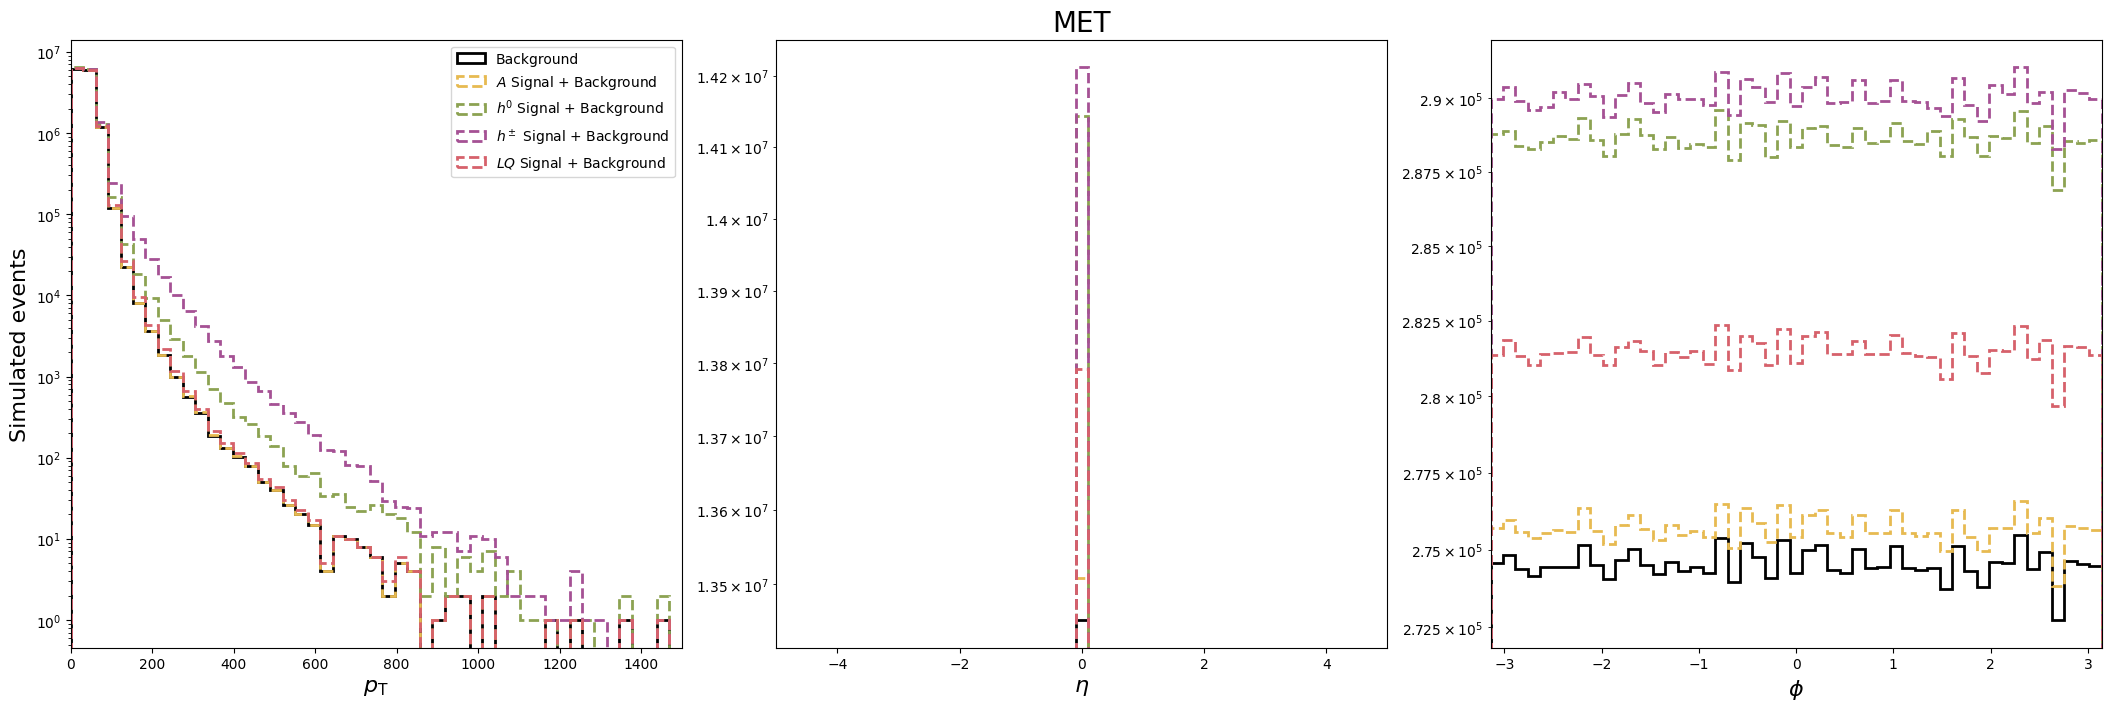

In [31]:
# Make plot
plotArgDict = {}
plotArgDict['pltDim']             = (1,3) # i.e. 1 row, 3 columns
plotArgDict['xAxisLimsList']      = [(0, 1500), (-5, 5), (-np.pi, np.pi)]
plotArgDict['title']              = r'MET'
plotArgDict['nBins']              = 50
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotDataHists(objectBkg, objectSigList, plotArgDict)

## Plot multiplicities of different categories for Signal vs Background

As pointed out [in this paper](https://arxiv.org/pdf/2301.04660.pdf), the multiplicity of different types of objects can potentially be a good indicator of whether that event is background or some kind of signal. There are 3 object types which can have varying multiplicity: $e$, $\mu$, and ${\rm jet}$. Here we'll plot the multiplicity (i.e. number of _) in each type for background and each signal categories.

In [32]:
# Define colors to use for 4 signal types
SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                              RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                              RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                              RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                              ])

In [33]:
# Prepare object data for plotting
objectsBkg = dataDict['bkg']['Particles'][:, :, 0] # Only need pT data

objectsSigList = []
for alias in sigAliasList:
  objectsSigList.append(dataDict[alias]['Particles'][:, :, 0]) # Only need pT data

multBkgList, multSigList = calcMultiplicityData(objectsBkg, objectsSigList)

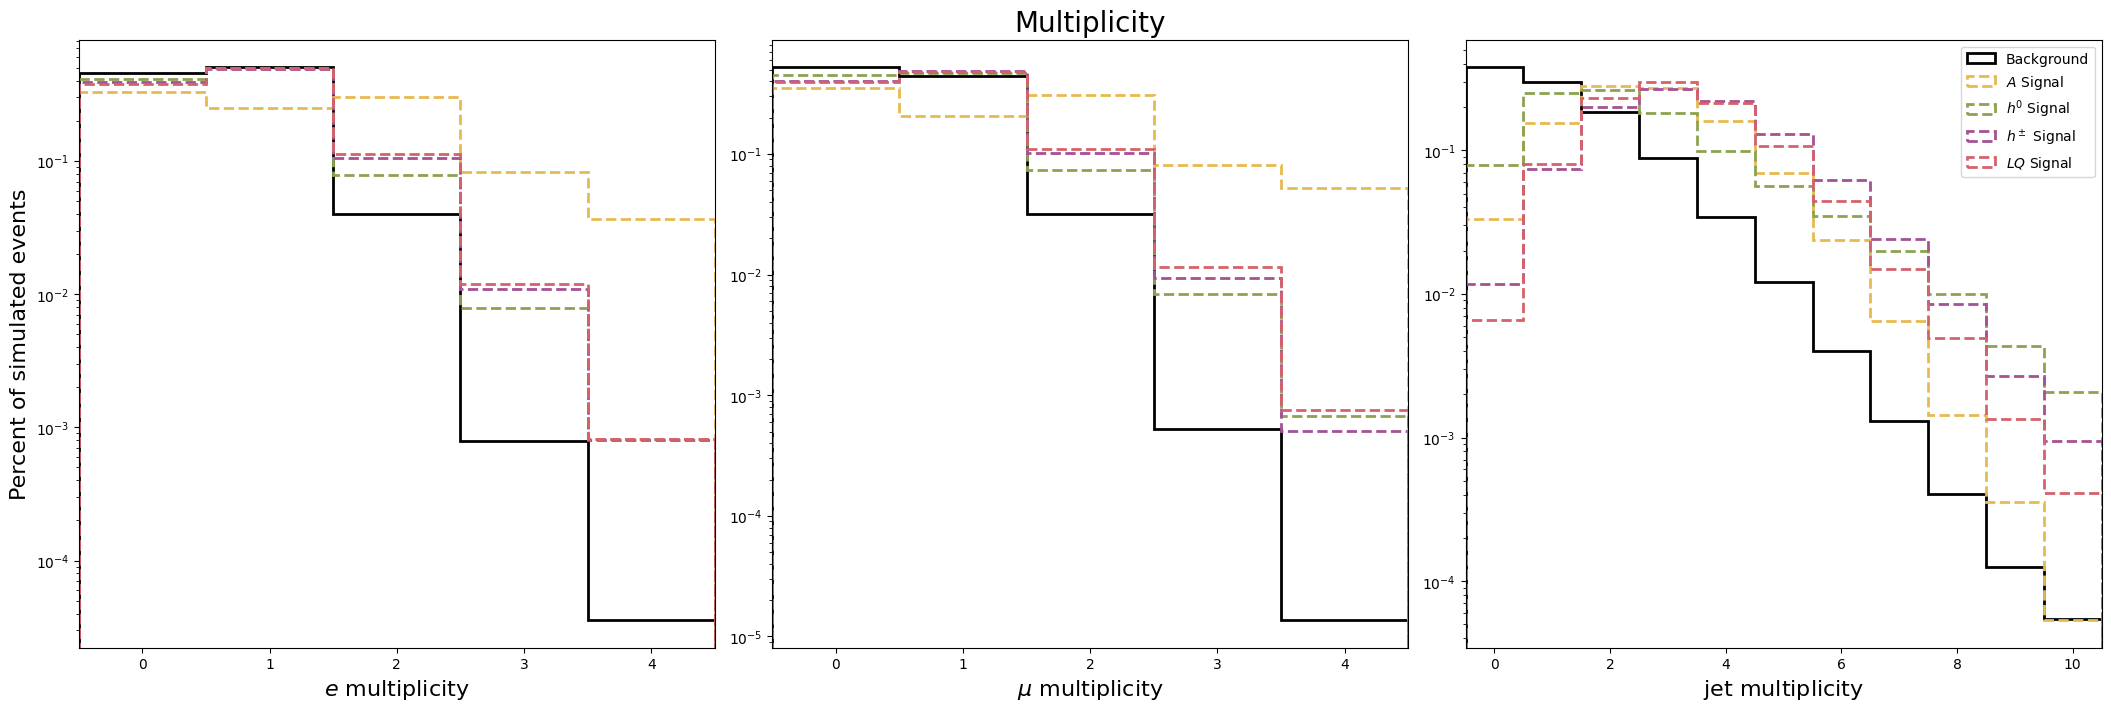

In [34]:
# Make plot
plotArgDict = {}
plotArgDict['pltDim']             = (1,3) # i.e. 1 row, 3 columns
plotArgDict['xAxisLimsList']      = [(-0.5, 4.5), (-0.5, 4.5), (-0.5, 10.5)]
plotArgDict['title']              = r'Multiplicity'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotMultiplicityData(multBkgList[0:3], multSigList[0:3], plotArgDict)

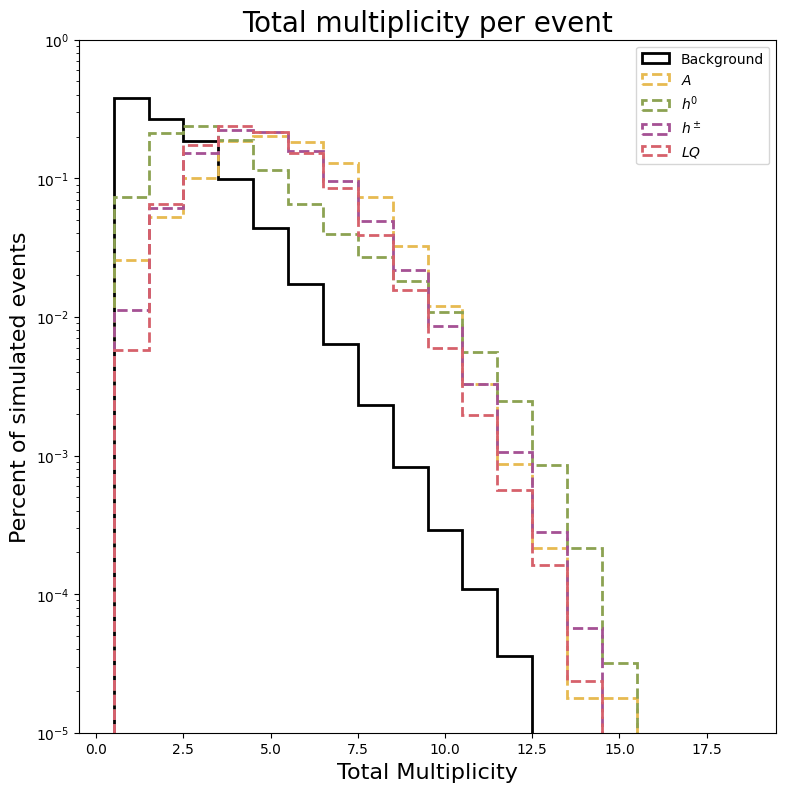

In [35]:
# Make total multiplicity plot
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (-0.5, 19.5)
plotArgDict['xLabel']             = r'Total Multiplicity'
plotArgDict['yAxisLims']          = (1e-5, 1)
plotArgDict['yLabel']             = 'Percent of simulated events'
plotArgDict['title']              = r'Total multiplicity per event'
plotArgDict['nBins']              = 21
plotArgDict['logY']               = True
plotArgDict['density']            = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(multBkgList[3], multSigList[3], plotArgDict)

## We can also plot the total $p_T$ in an event for Signal vs Background

In [36]:
# Define colors to use for 4 signal types
SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                              RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                              RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                              RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                              ])

In [37]:
# Prepare object data for plotting
totPtBkg = np.sum(dataDict['bkg']['Particles'][:, :, 0], axis=1)

totPtSigList = []
for alias in sigAliasList:
  totPtSigList.append(np.sum(dataDict[alias]['Particles'][:, :, 0], axis=1))

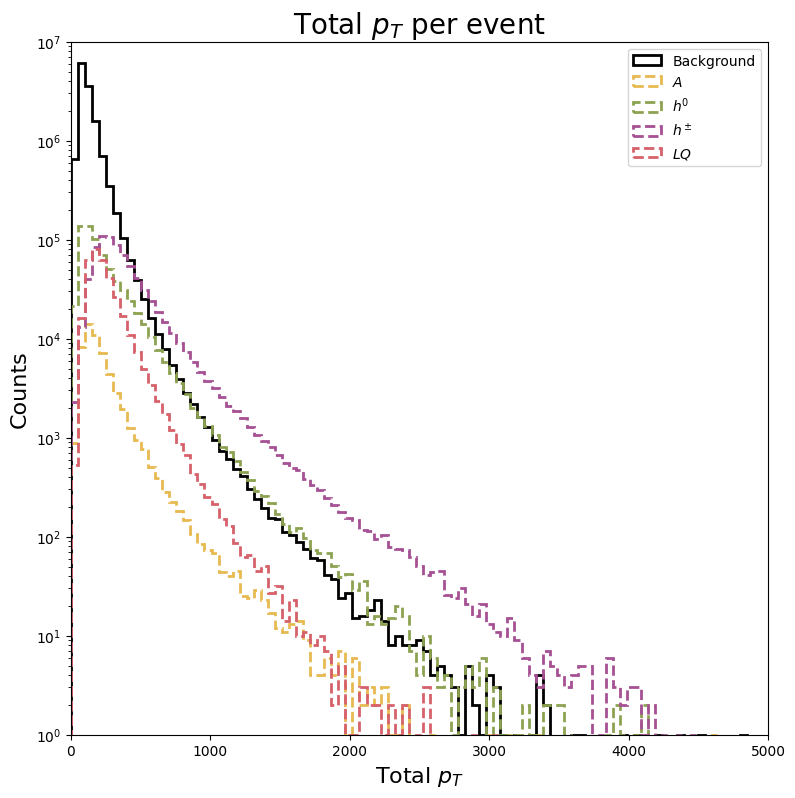

In [38]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 5000)
plotArgDict['xLabel']             = r'Total $p_T$'
plotArgDict['yAxisLims']          = (1, 1e7)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r'Total $p_T$ per event'
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(totPtBkg, totPtSigList, plotArgDict)

# Unbalanced 2-Wasserstein distance (L2, $\kappa = 0.1$)

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [77]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

## Calculate OT anomaly scores

In [78]:
# nEvents = 100 takes about xxs of wall-clock time

div, kappa = 'l2', 0.1

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], div=div, reg_m=kappa)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict[alias], div=div, reg_m=kappa)

In [79]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [80]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

## Plot anomaly scores for all signal types

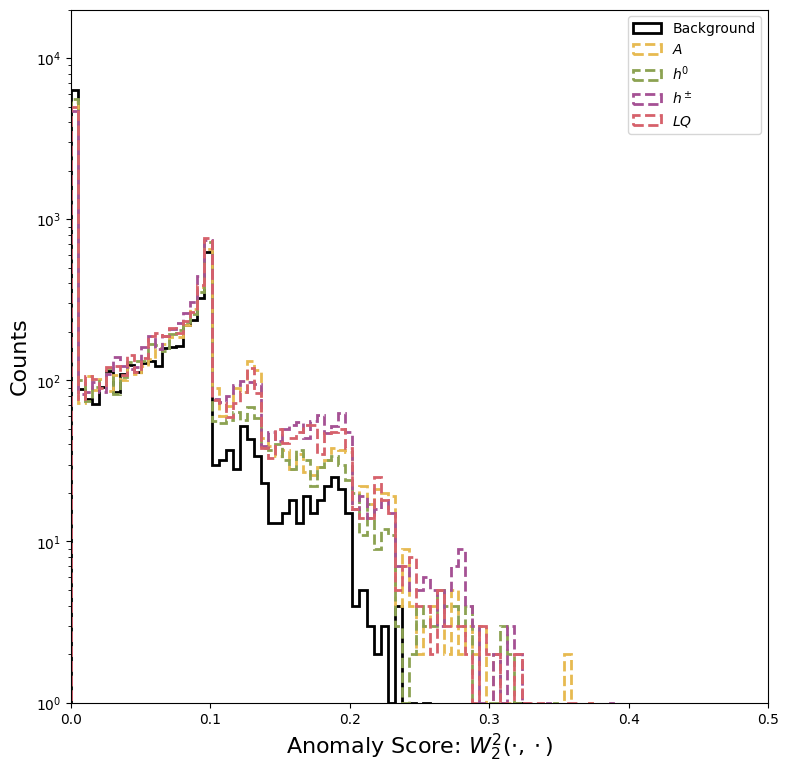

In [83]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 0.5)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 2e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Get AUCs, ROC, and SI curves

In [84]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

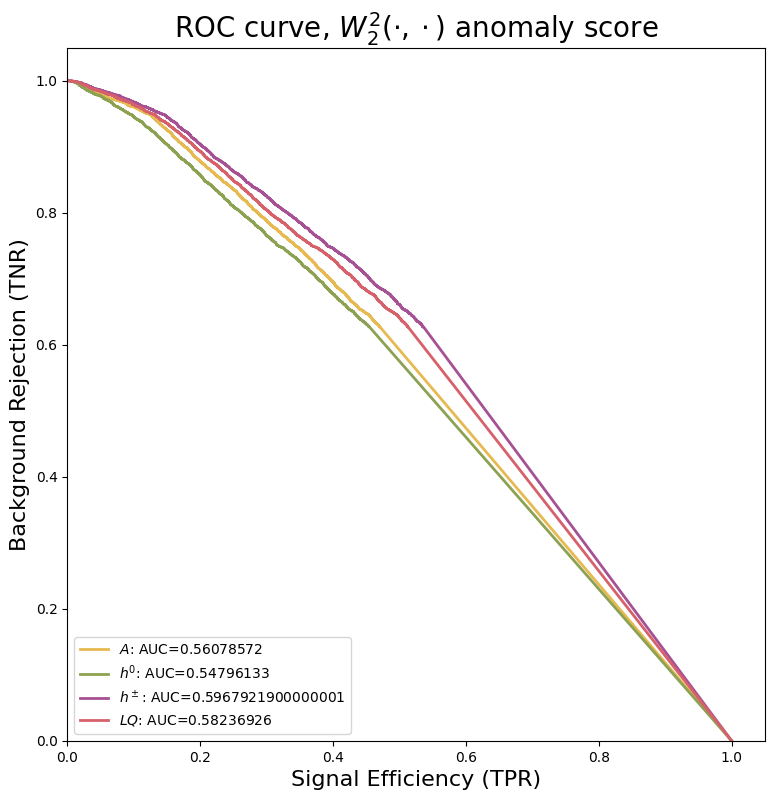

In [85]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

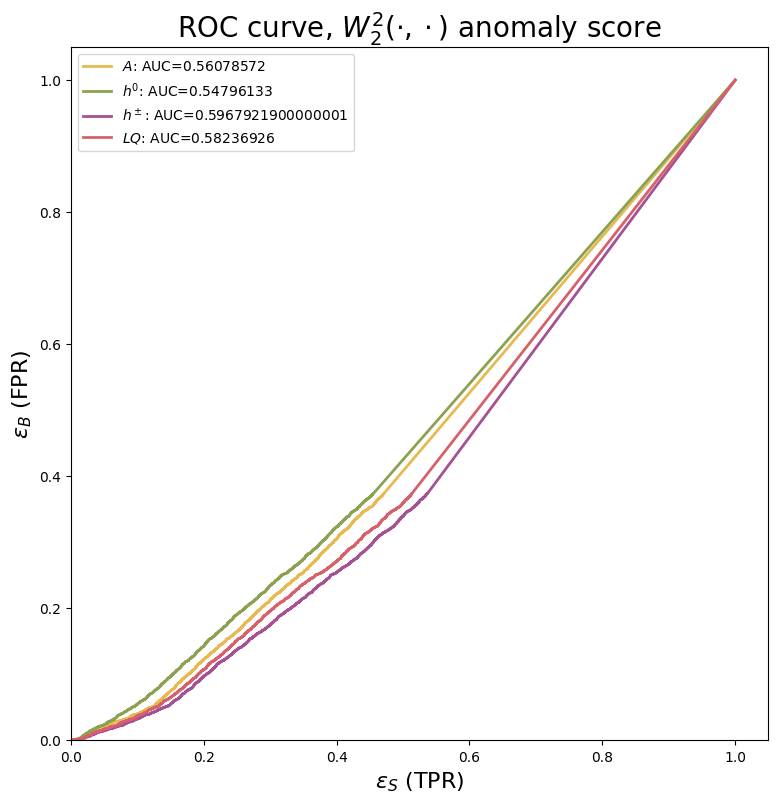

In [86]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

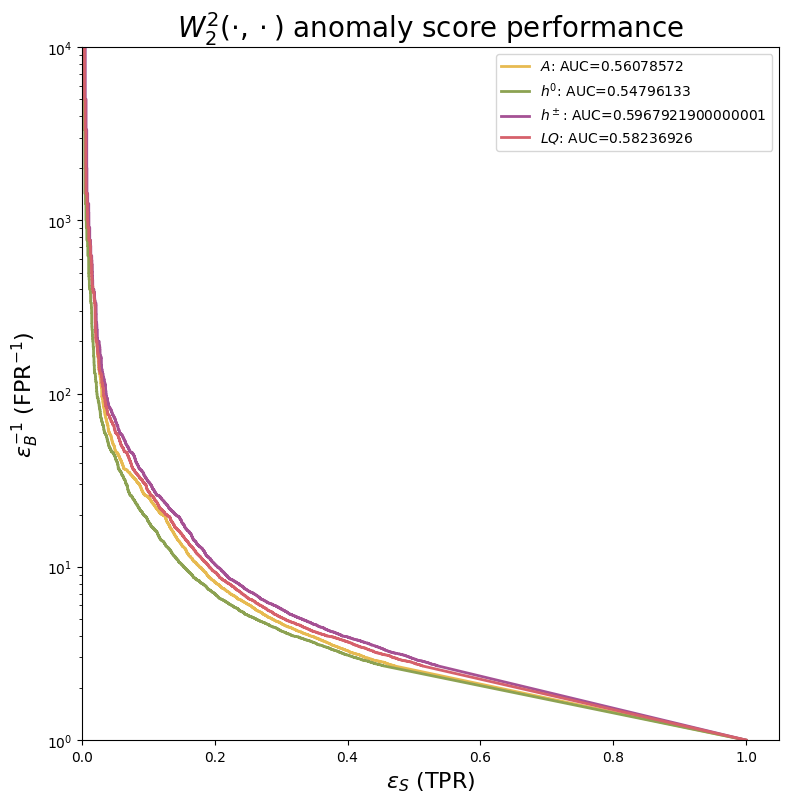

In [87]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 1e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

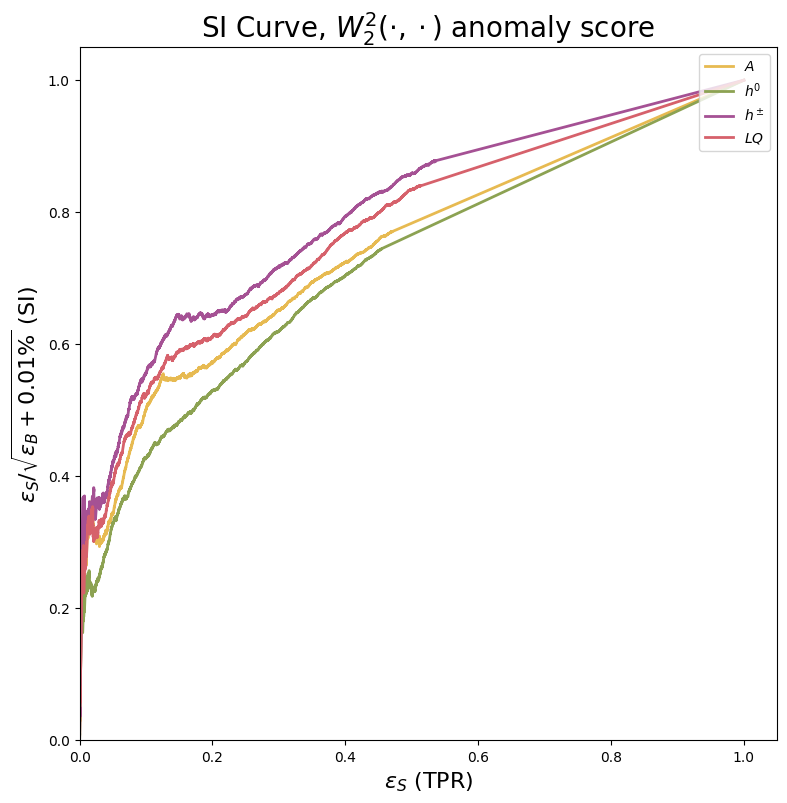

In [88]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [89]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0001 0.0005 0.0005 0.0052]
[0.         0.01       0.05       0.03535534 0.36769553]


## Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [90]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [91]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.56078572
     $h^0$: 0.54796133
   $h^\pm$: 0.5967921900000001
      $LQ$: 0.58236926


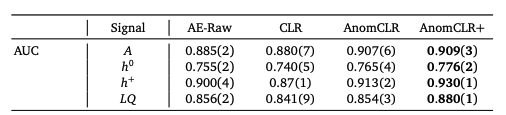

#### Inverse FPR (at TPR = 0.3):

In [92]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[2354, 2597, 2130, 2328]


In [93]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 4.721435316336167 (TPR=0.3)
     $h^0$: 4.271678769756514 (TPR=0.3)
   $h^\pm$: 5.730659025787966 (TPR=0.2999)
      $LQ$: 5.109862033725089 (TPR=0.3001)


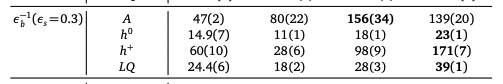

#### SI (at TPR = 0.3):

In [94]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.6517120879556718 (TPR=0.3)
     $h^0$: 0.6199088112329391 (TPR=0.3)
   $h^\pm$: 0.7177188392315322 (TPR=0.2999)
      $LQ$: 0.6782029143657057 (TPR=0.3001)


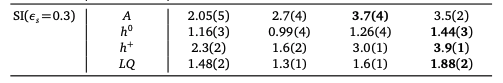

# Unbalanced 2-Wasserstein distance (L2, $\kappa = 1$)

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [39]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

## Calculate OT anomaly scores

In [40]:
# nEvents = 100 takes about xxs of wall-clock time

div, kappa = 'l2', 1

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], div=div, reg_m=kappa)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict[alias], div=div, reg_m=kappa)

In [41]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [42]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

## Plot anomaly scores for all signal types

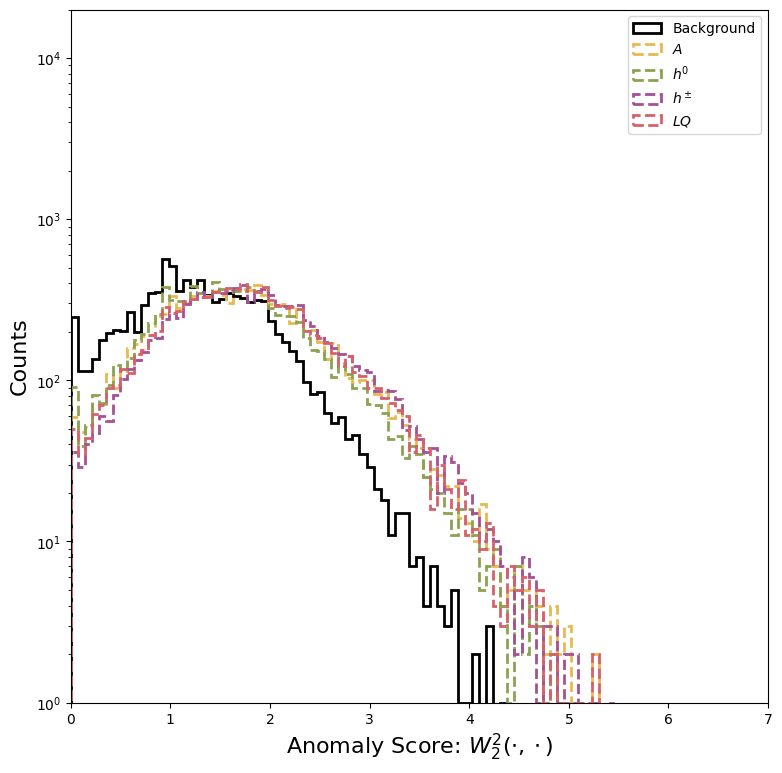

In [45]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 7)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 2e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Get AUCs, ROC, and SI curves

In [46]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

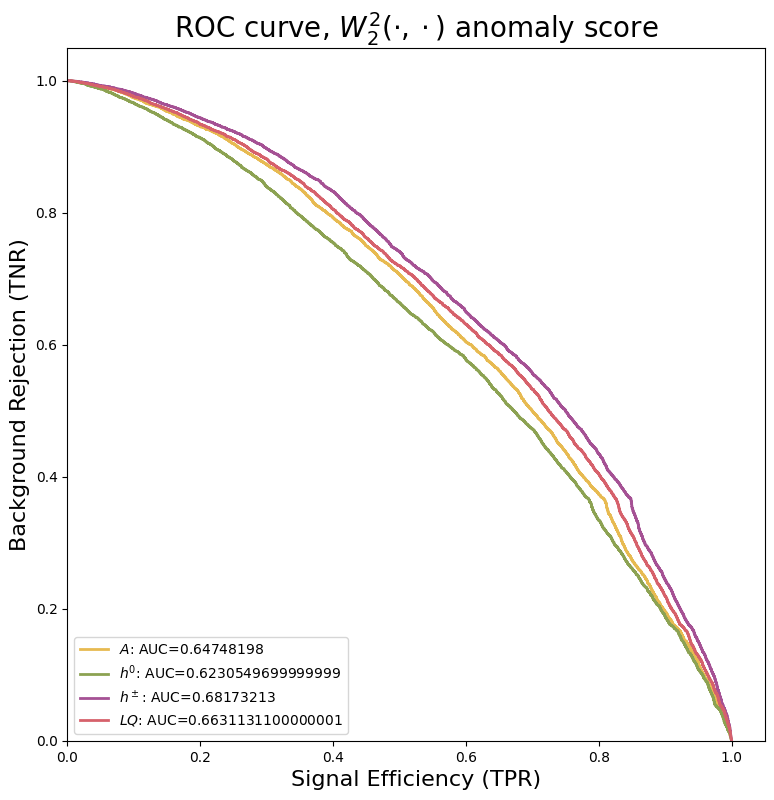

In [47]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

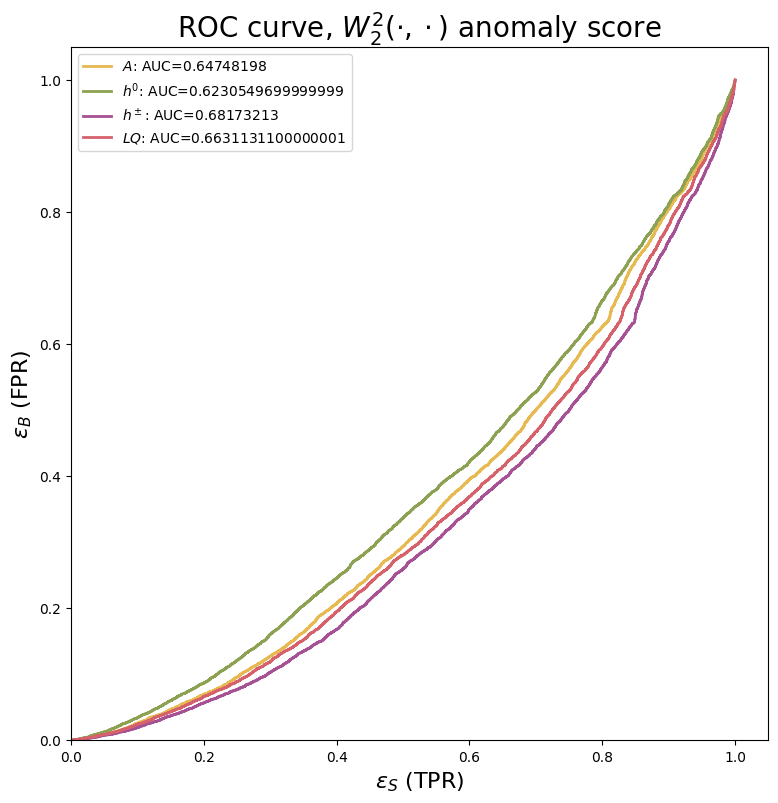

In [48]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

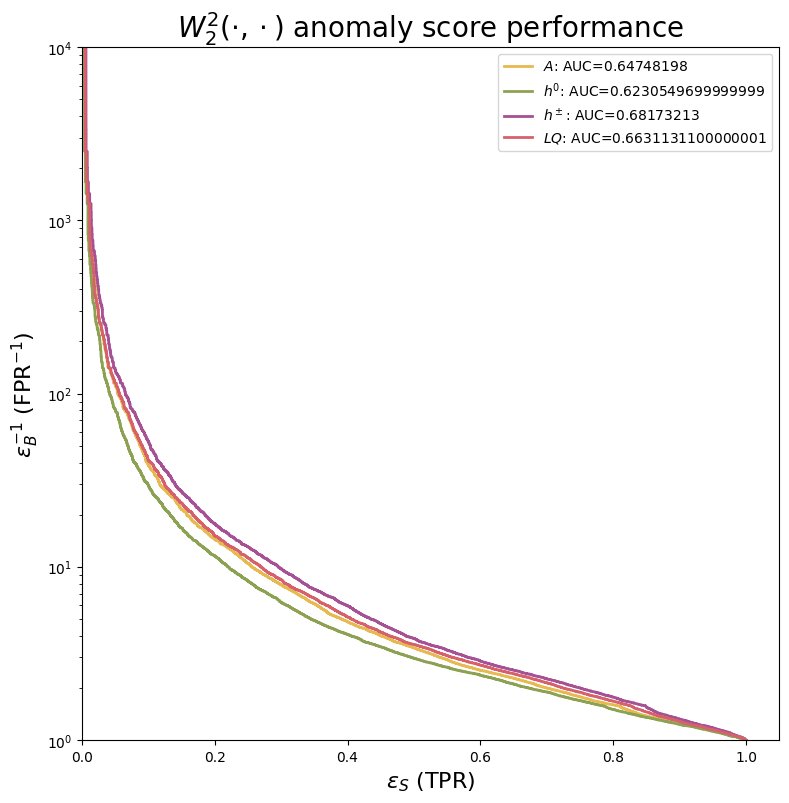

In [49]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 1e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

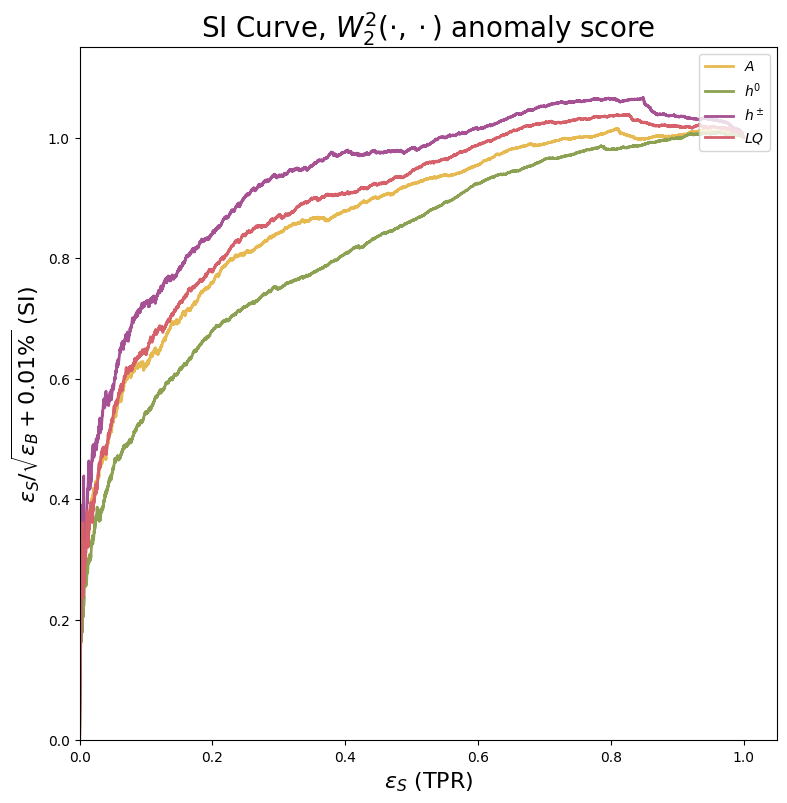

In [58]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.15)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [51]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0001 0.0039 0.0039 0.0062]
[0.         0.01       0.39       0.27577164 0.4384062 ]


## Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [52]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [53]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.64748198
     $h^0$: 0.6230549699999999
   $h^\pm$: 0.68173213
      $LQ$: 0.6631131100000001


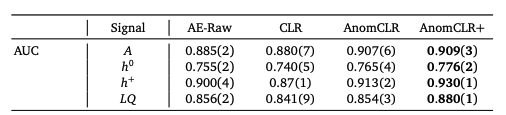

#### Inverse FPR (at TPR = 0.3):

In [54]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[1756, 2062, 1502, 1648]


In [55]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 7.874015748031496 (TPR=0.3)
     $h^0$: 6.242197253433208 (TPR=0.3)
   $h^\pm$: 9.775171065493646 (TPR=0.2997)
      $LQ$: 8.438818565400844 (TPR=0.3001)


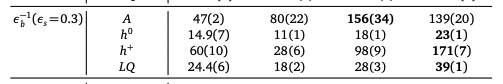

#### SI (at TPR = 0.3):

In [56]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.8414890701798216 (TPR=0.3)
     $h^0$: 0.7492978622271093 (TPR=0.3)
   $h^\pm$: 0.9365625000000001 (TPR=0.2997)
      $LQ$: 0.871412230160631 (TPR=0.3001)


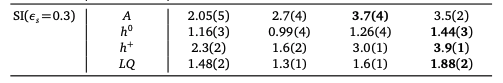

# Unbalanced 2-Wasserstein distance (L2, $\kappa = 5$)

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [59]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

## Calculate OT anomaly scores

In [60]:
# nEvents = 100 takes about xxs of wall-clock time

div, kappa = 'l2', 5

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], div=div, reg_m=kappa)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict[alias], div=div, reg_m=kappa)

In [61]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [62]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

## Plot anomaly scores for all signal types

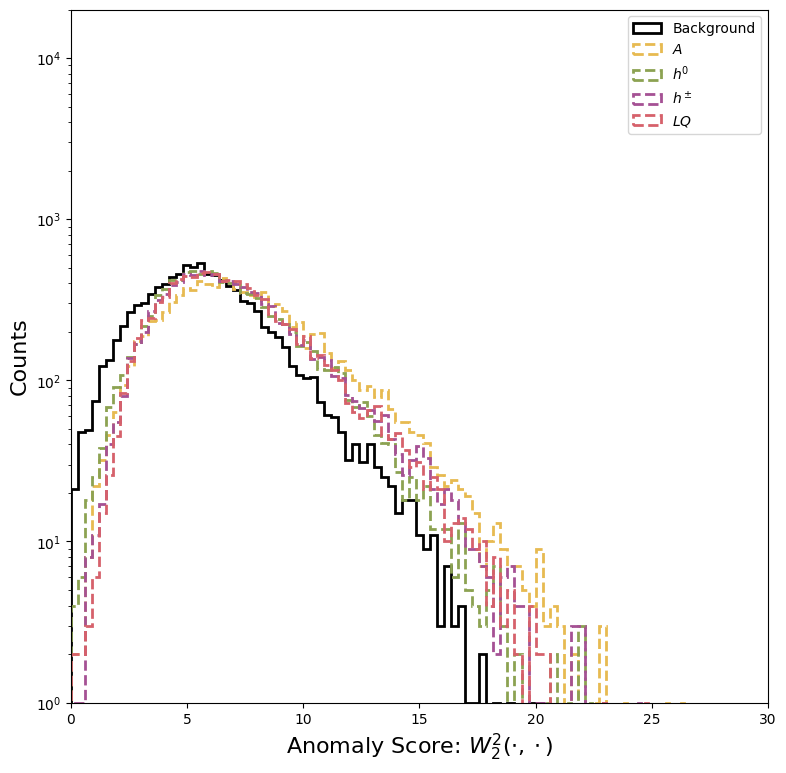

In [65]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 30)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 2e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Get AUCs, ROC, and SI curves

In [66]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

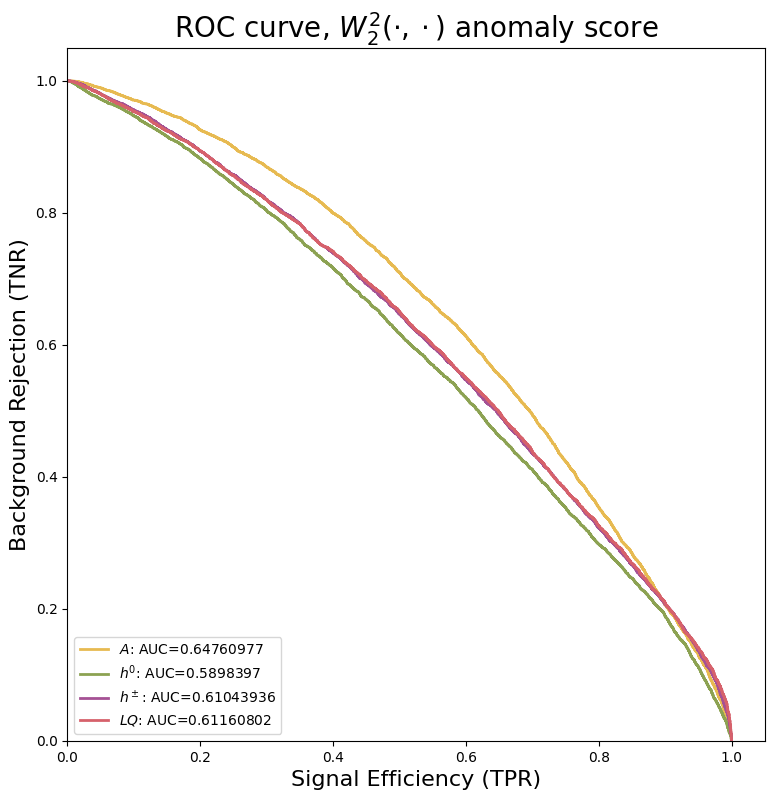

In [67]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

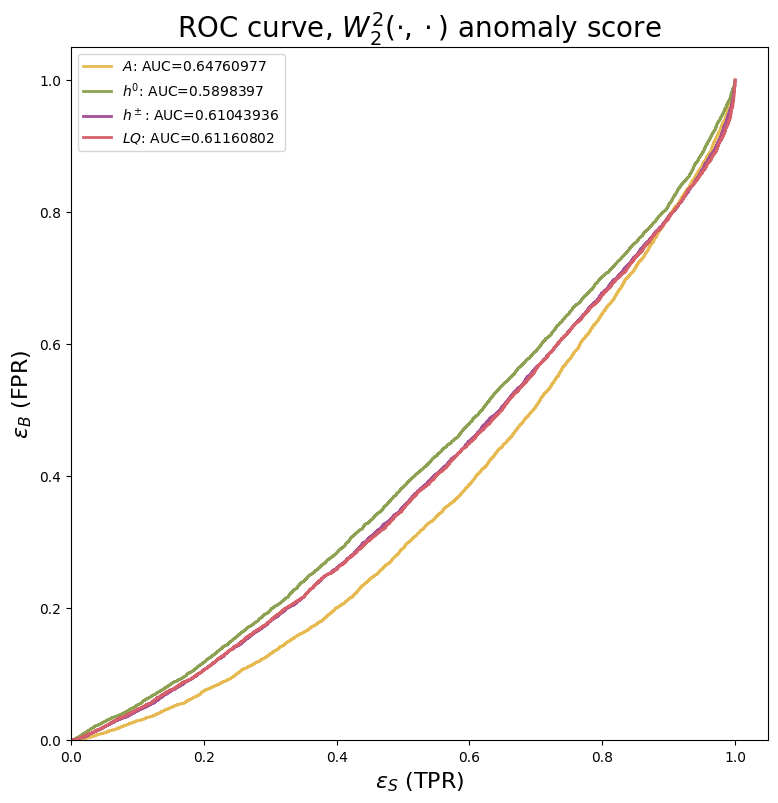

In [68]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

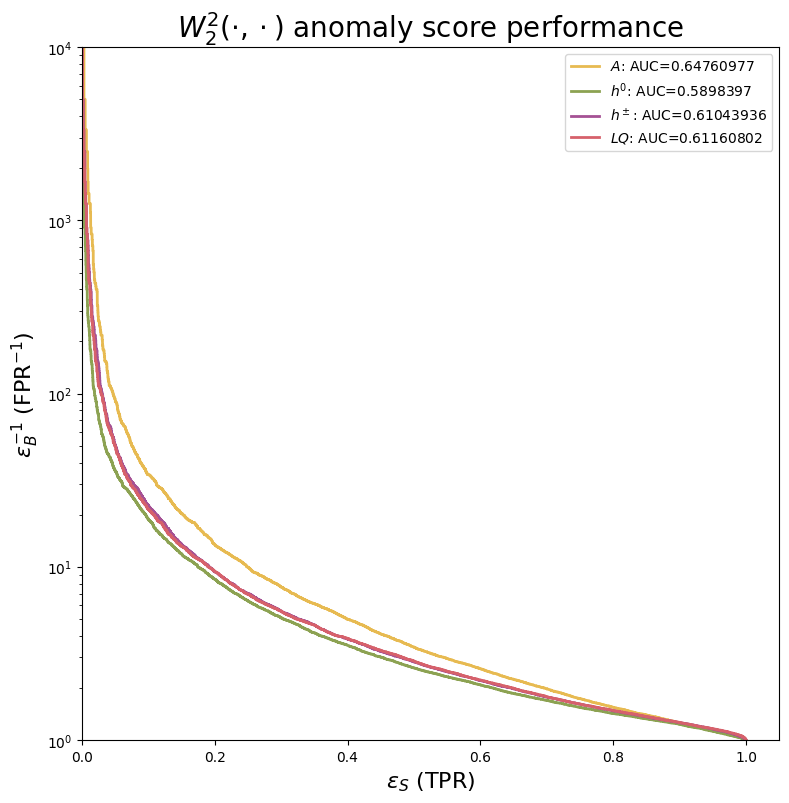

In [69]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 1e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

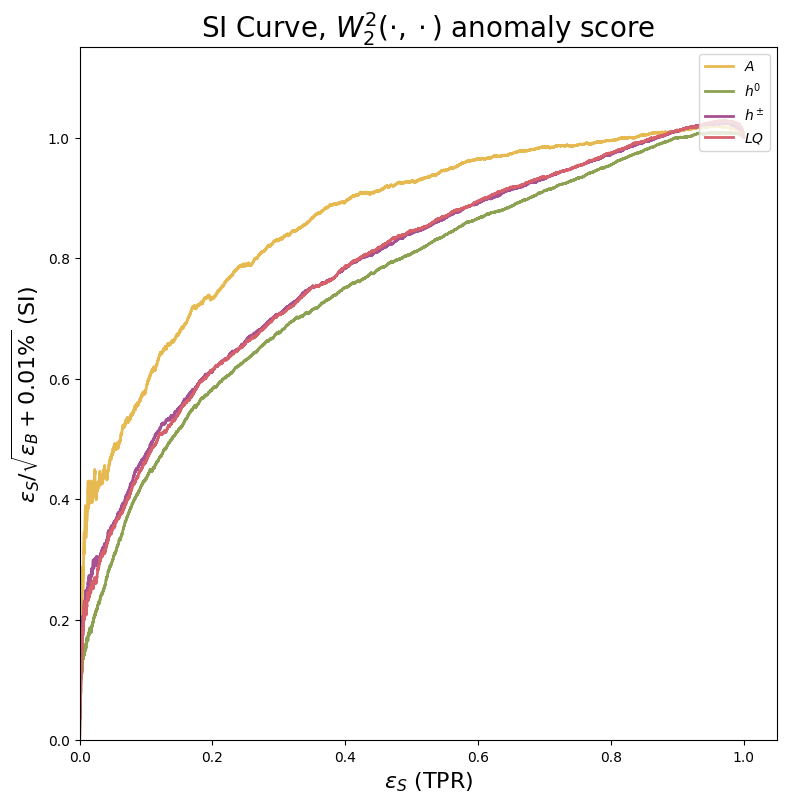

In [70]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.15)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [71]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0001 0.001  0.001  0.0011]
[0.         0.01       0.1        0.07071068 0.07778175]


## Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [72]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [73]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.64760977
     $h^0$: 0.5898397
   $h^\pm$: 0.61043936
      $LQ$: 0.61160802


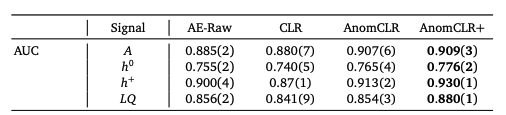

#### Inverse FPR (at TPR = 0.3):

In [74]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[1774, 2394, 2190, 2202]


In [75]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 7.656967840735069 (TPR=0.2999)
     $h^0$: 5.099439061703213 (TPR=0.3)
   $h^\pm$: 5.558643690939411 (TPR=0.3)
      $LQ$: 5.555555555555555 (TPR=0.2998)


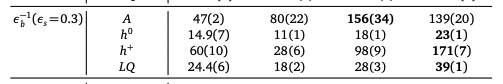

#### SI (at TPR = 0.3):

In [76]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.8295425588384565 (TPR=0.2999)
     $h^0$: 0.6772854614785964 (TPR=0.3)
   $h^\pm$: 0.7071067811865475 (TPR=0.3)
      $LQ$: 0.7064391708097834 (TPR=0.2998)


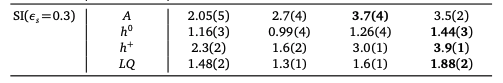

# Unbalanced 2-Wasserstein distance (KL, $\kappa = 0.1$)

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [39]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

## Calculate OT anomaly scores

In [40]:
# nEvents = 100 takes about xxs of wall-clock time

div, kappa = 'kl', 0.1

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], div=div, reg_m=kappa)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict[alias], div=div, reg_m=kappa)

In [41]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [42]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

## Plot anomaly scores for all signal types

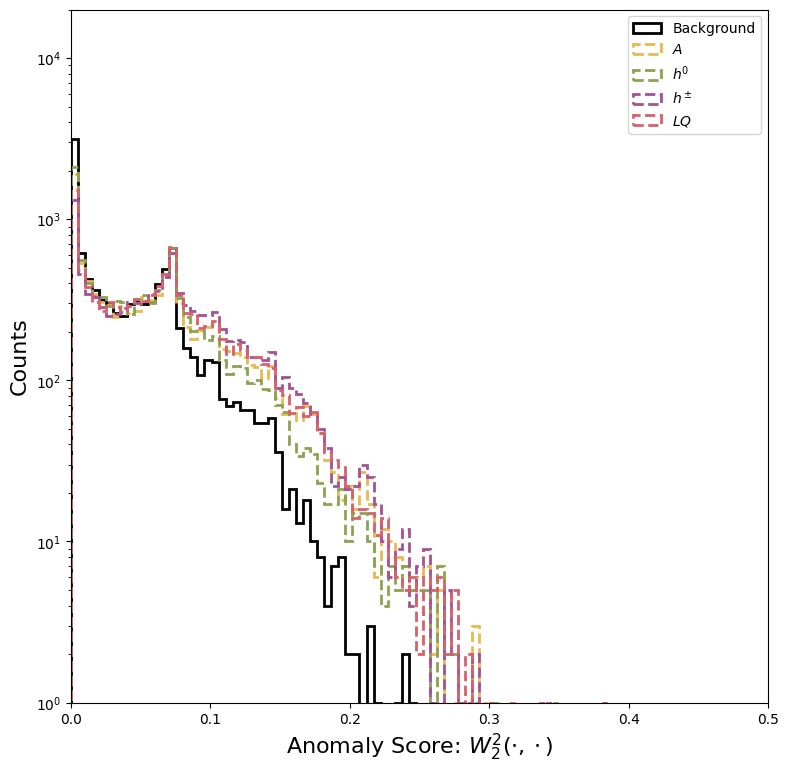

In [43]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 0.5)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 2e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Get AUCs, ROC, and SI curves

In [44]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

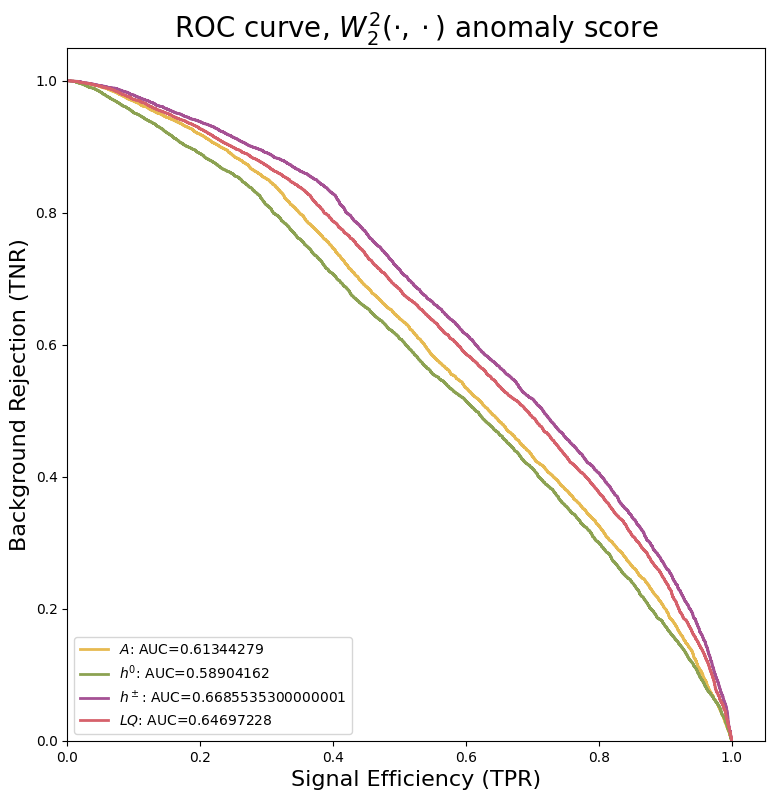

In [45]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

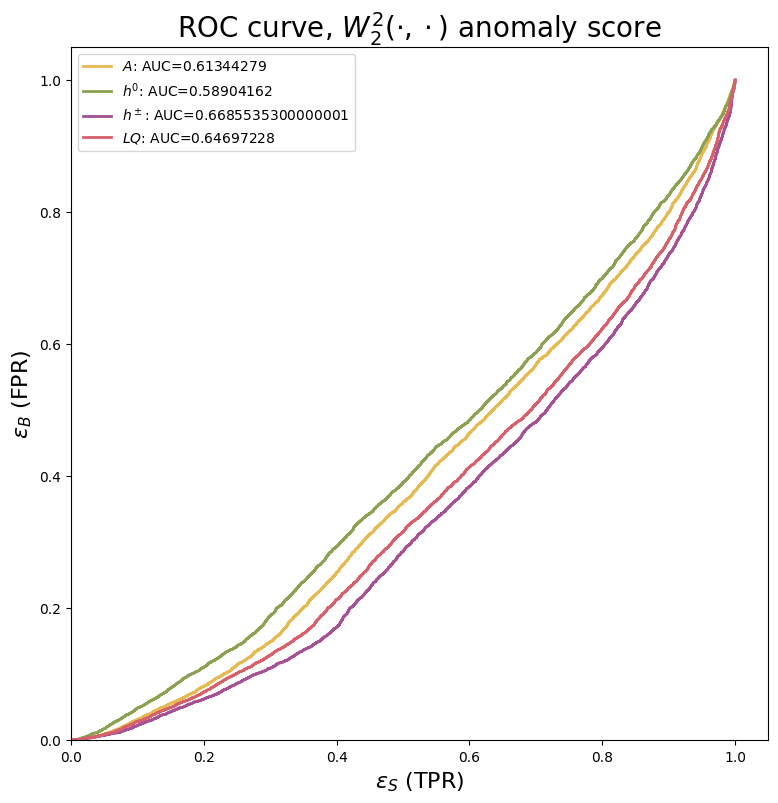

In [46]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

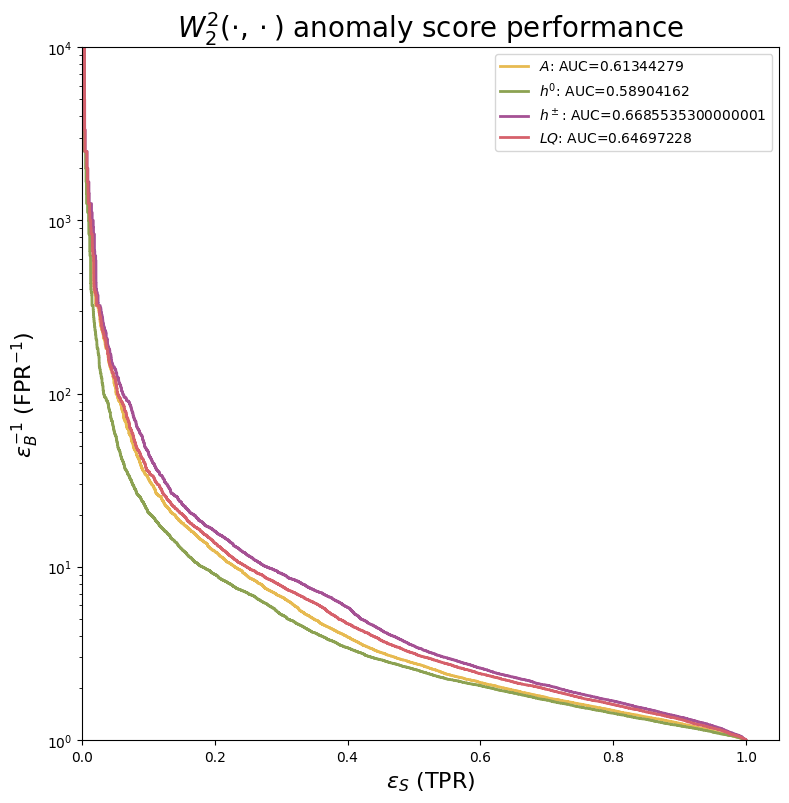

In [47]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 1e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

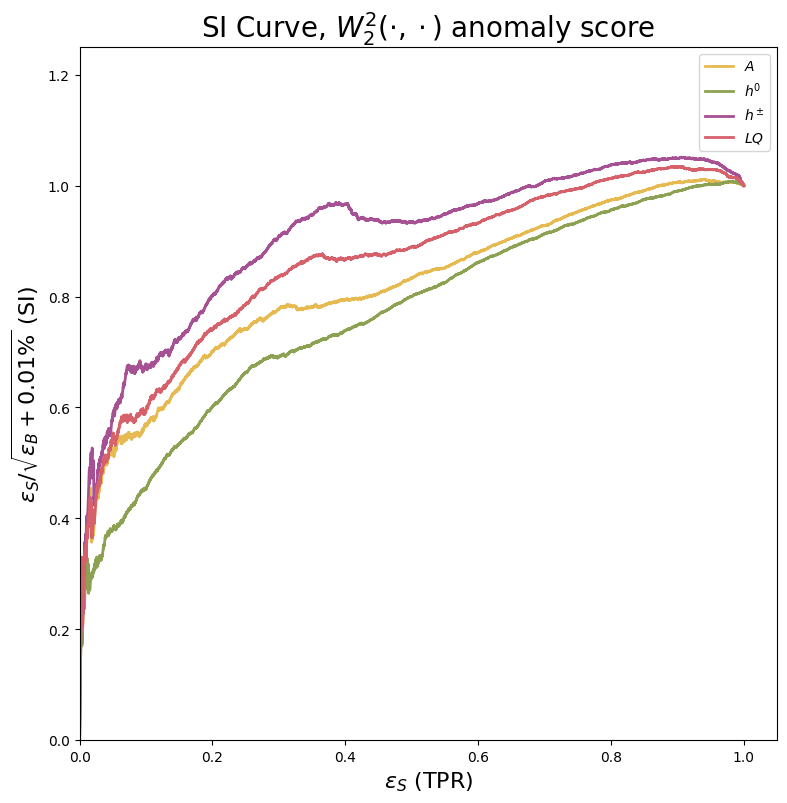

In [48]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.25)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [49]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0001 0.0032 0.0032 0.0037]
[0.         0.01       0.32       0.22627417 0.26162951]


## Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [50]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [51]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.61344279
     $h^0$: 0.58904162
   $h^\pm$: 0.6685535300000001
      $LQ$: 0.64697228


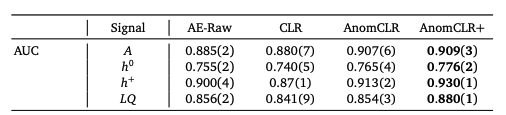

#### Inverse FPR (at TPR = 0.3):

In [52]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[1916, 2278, 1536, 1776]


In [53]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 6.729475100942126 (TPR=0.2998)
     $h^0$: 5.31632110579479 (TPR=0.3)
   $h^\pm$: 9.191176470588236 (TPR=0.2999)
      $LQ$: 7.776049766718508 (TPR=0.2999)


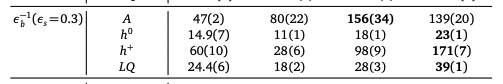

#### SI (at TPR = 0.3):

In [54]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.7774565812374876 (TPR=0.2998)
     $h^0$: 0.6915306683363611 (TPR=0.3)
   $h^\pm$: 0.9087878787878787 (TPR=0.2999)
      $LQ$: 0.8359632626704218 (TPR=0.2999)


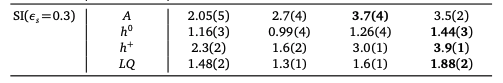

# Unbalanced 2-Wasserstein distance (KL, $\kappa = 1$)

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [55]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

## Calculate OT anomaly scores

In [56]:
# nEvents = 100 takes about xxs of wall-clock time

div, kappa = 'kl', 1

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], div=div, reg_m=kappa)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict[alias], div=div, reg_m=kappa)

In [57]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [58]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

## Plot anomaly scores for all signal types

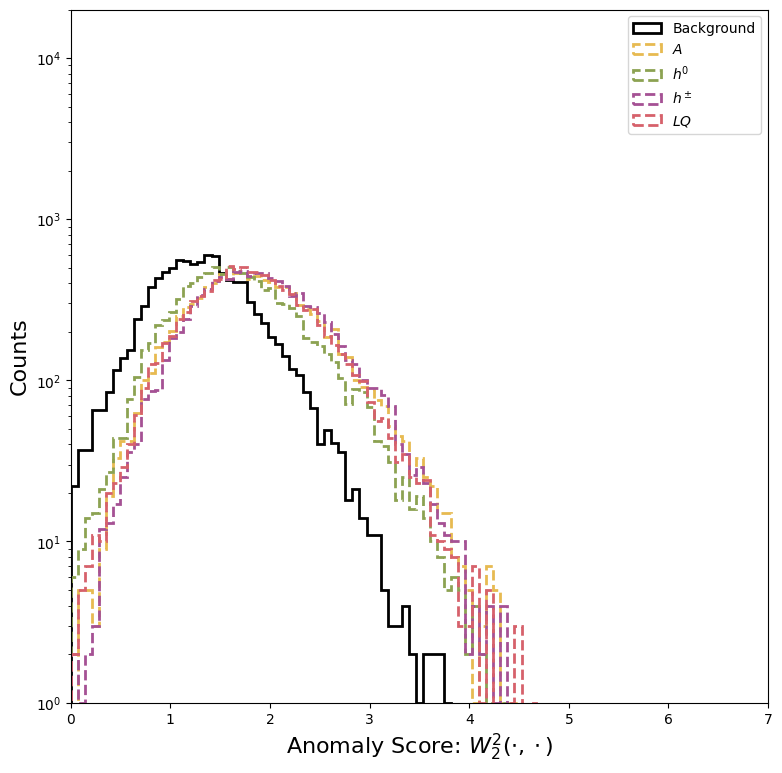

In [59]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 7)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 2e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Get AUCs, ROC, and SI curves

In [60]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

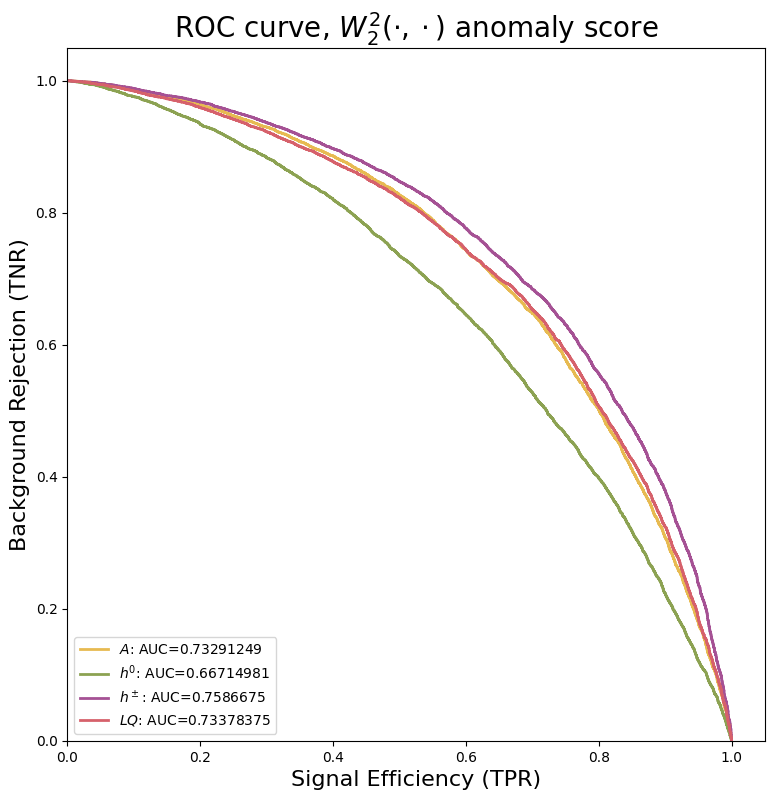

In [61]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

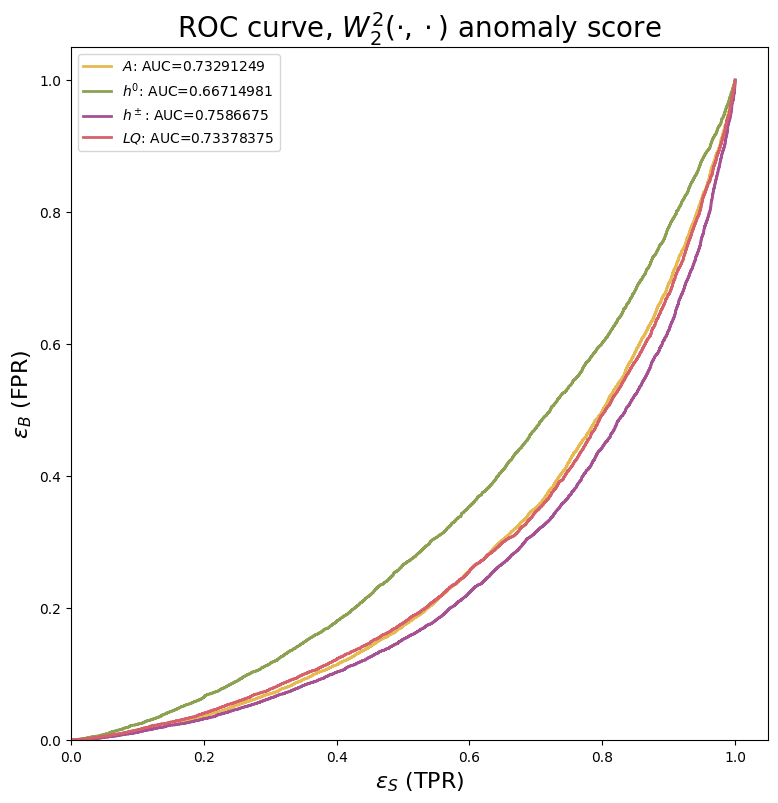

In [62]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

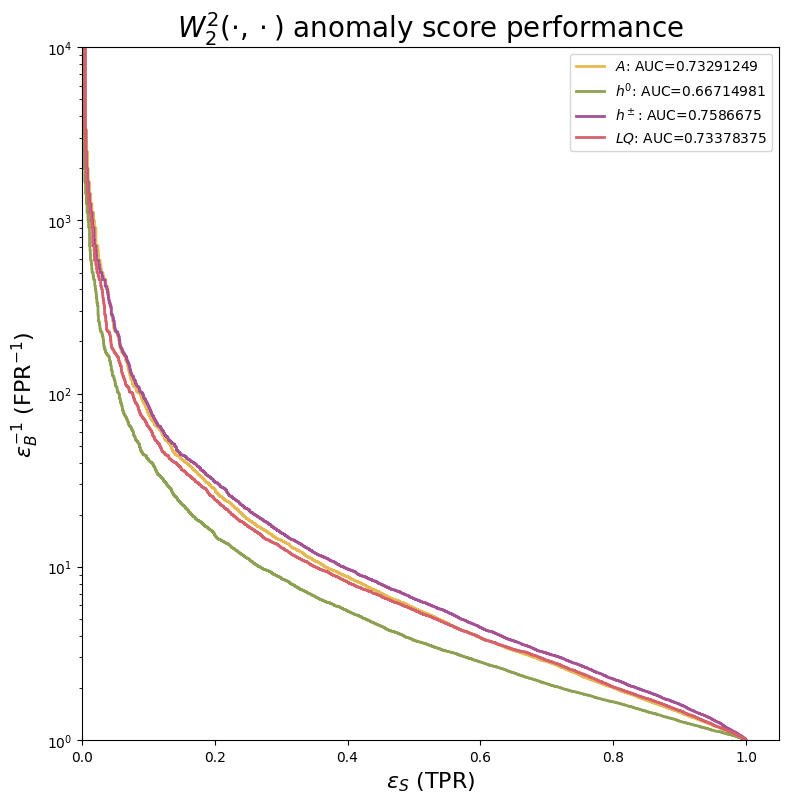

In [63]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 1e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

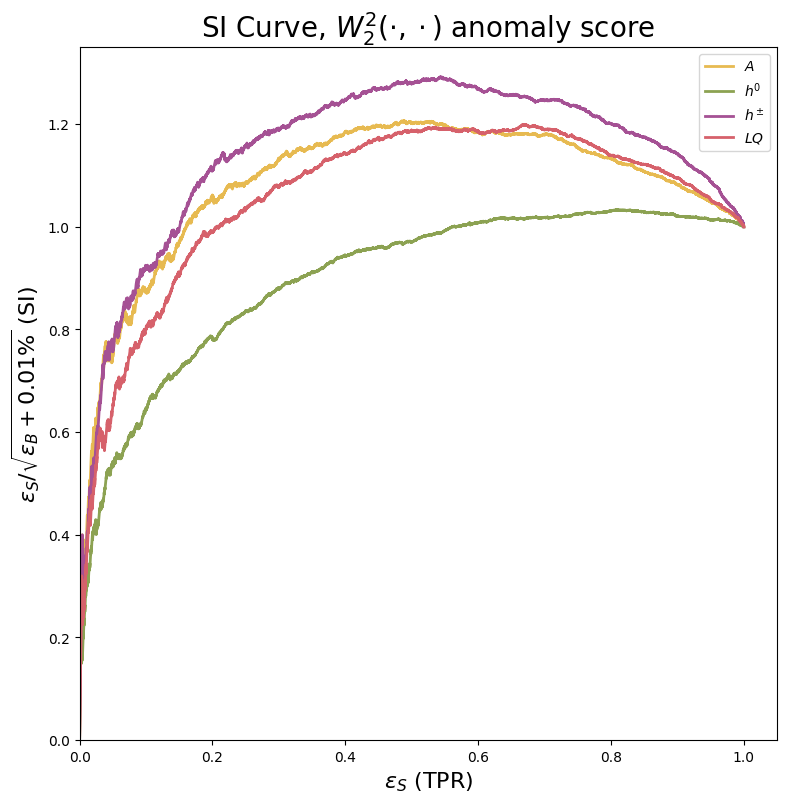

In [71]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.35)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [65]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0001 0.004  0.004  0.0051]
[0.         0.01       0.4        0.28284271 0.36062446]


## Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [66]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [67]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.73291249
     $h^0$: 0.66714981
   $h^\pm$: 0.7586675
      $LQ$: 0.73378375


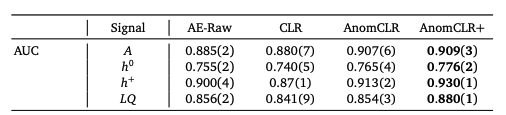

#### Inverse FPR (at TPR = 0.3):

In [68]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[1072, 1644, 1044, 1196]


In [69]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 14.306151645207438 (TPR=0.2998)
     $h^0$: 8.605851979345955 (TPR=0.3)
   $h^\pm$: 15.748031496062993 (TPR=0.3004)
      $LQ$: 12.903225806451614 (TPR=0.3)


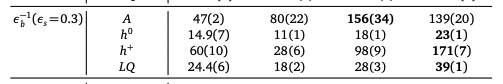

#### SI (at TPR = 0.3):

In [70]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 1.133137490081663 (TPR=0.2998)
     $h^0$: 0.8796935290617334 (TPR=0.3)
   $h^\pm$: 1.1911634817486523 (TPR=0.3004)
      $LQ$: 1.0769372379266071 (TPR=0.3)


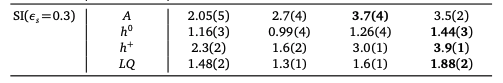

# Unbalanced 2-Wasserstein distance (KL, $\kappa = 2$)

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [88]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

## Calculate OT anomaly scores

In [89]:
# nEvents = 100 takes about xxs of wall-clock time

div, kappa = 'kl', 2

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], div=div, reg_m=kappa)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict[alias], div=div, reg_m=kappa)

In [90]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [91]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

## Plot anomaly scores for all signal types

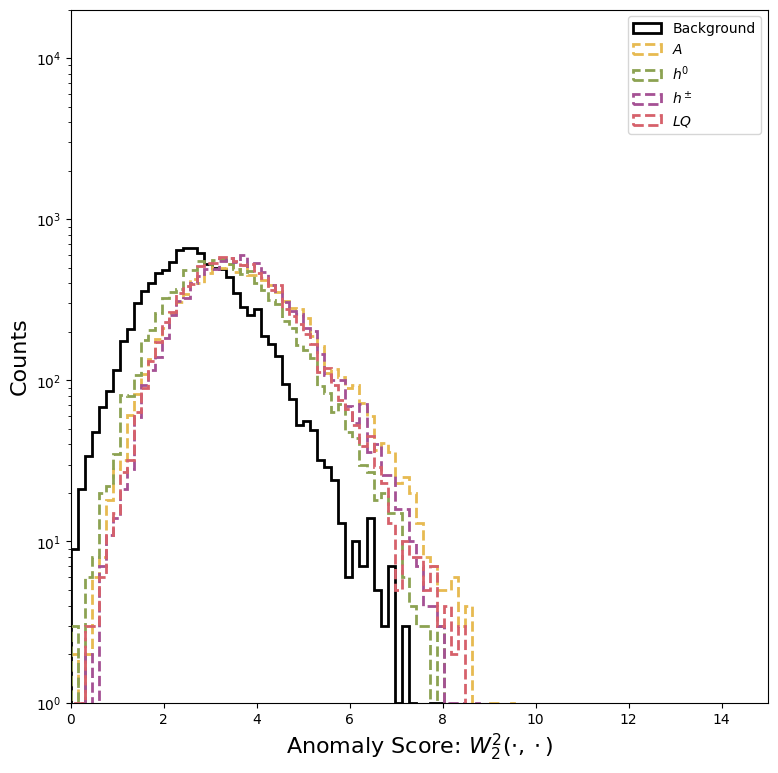

In [93]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 15)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 2e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Get AUCs, ROC, and SI curves

In [94]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

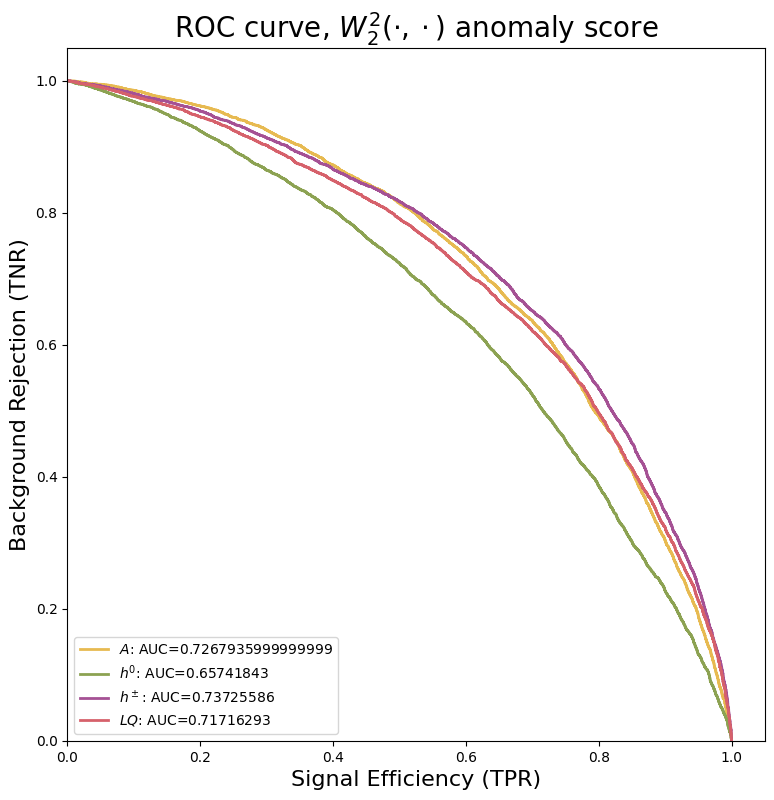

In [95]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

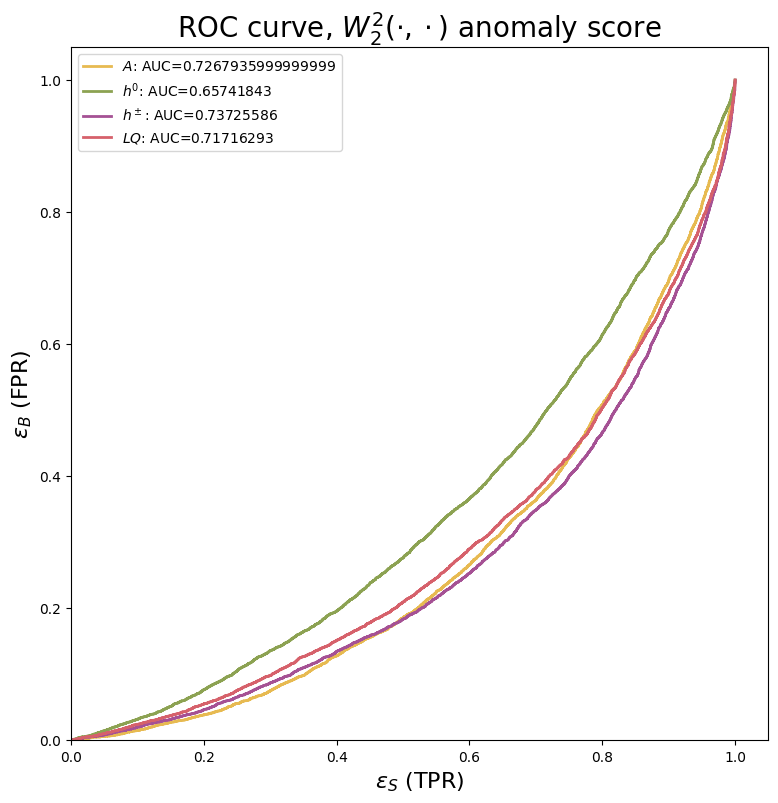

In [96]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

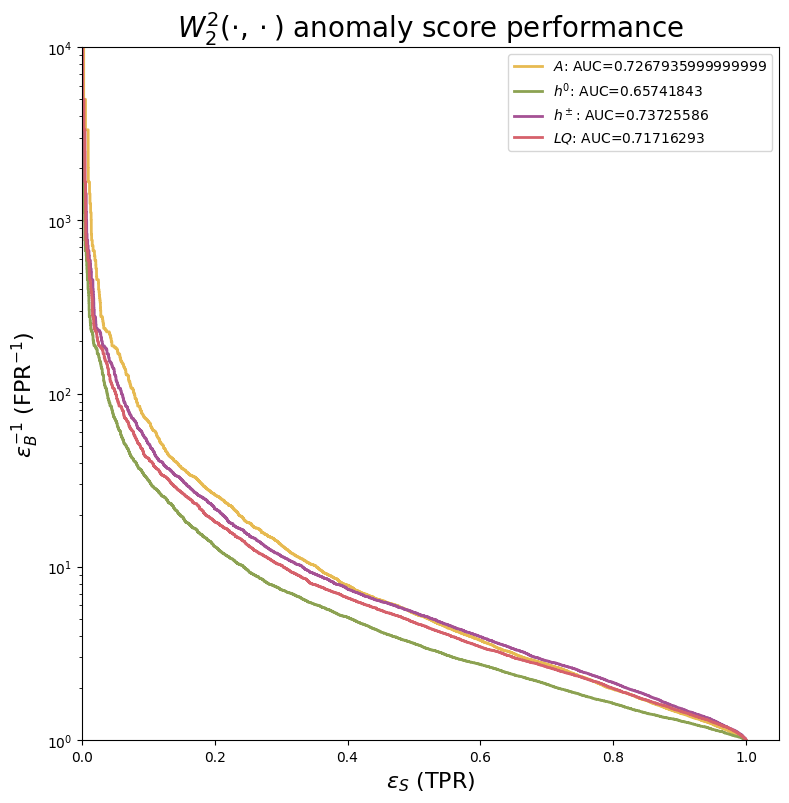

In [97]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 1e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

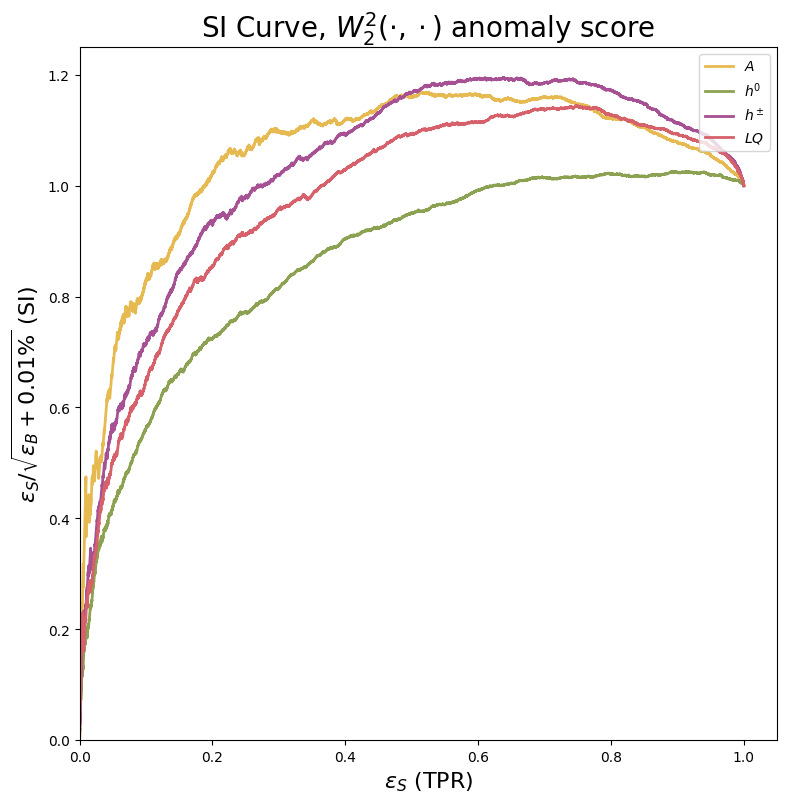

In [98]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.25)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [99]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0001 0.0004 0.0004 0.0007]
[0.         0.01       0.04       0.02828427 0.04949747]


## Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [100]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [101]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.7267935999999999
     $h^0$: 0.65741843
   $h^\pm$: 0.73725586
      $LQ$: 0.71716293


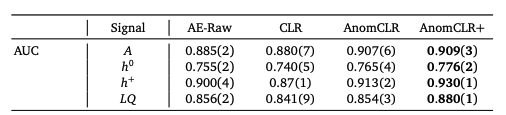

#### Inverse FPR (at TPR = 0.3):

In [102]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[1148, 1859, 1316, 1460]


In [103]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 13.440860215053764 (TPR=0.3)
     $h^0$: 7.396449704142013 (TPR=0.3)
   $h^\pm$: 11.574074074074073 (TPR=0.3)
      $LQ$: 10.245901639344261 (TPR=0.2998)


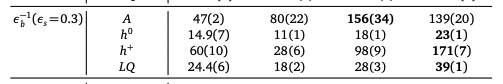

#### SI (at TPR = 0.3):

In [104]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 1.0991149581709676 (TPR=0.3)
     $h^0$: 0.8155908717405553 (TPR=0.3)
   $h^\pm$: 1.0200306013770688 (TPR=0.3)
      $LQ$: 0.959145175538325 (TPR=0.2998)


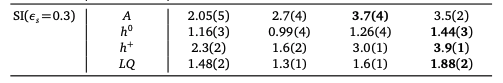

# Unbalanced 2-Wasserstein distance (KL, $\kappa = 5$)

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [72]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

## Calculate OT anomaly scores

In [73]:
# nEvents = 100 takes about xxs of wall-clock time

div, kappa = 'kl', 5

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], div=div, reg_m=kappa)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict[alias], div=div, reg_m=kappa)

In [74]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [75]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

## Plot anomaly scores for all signal types

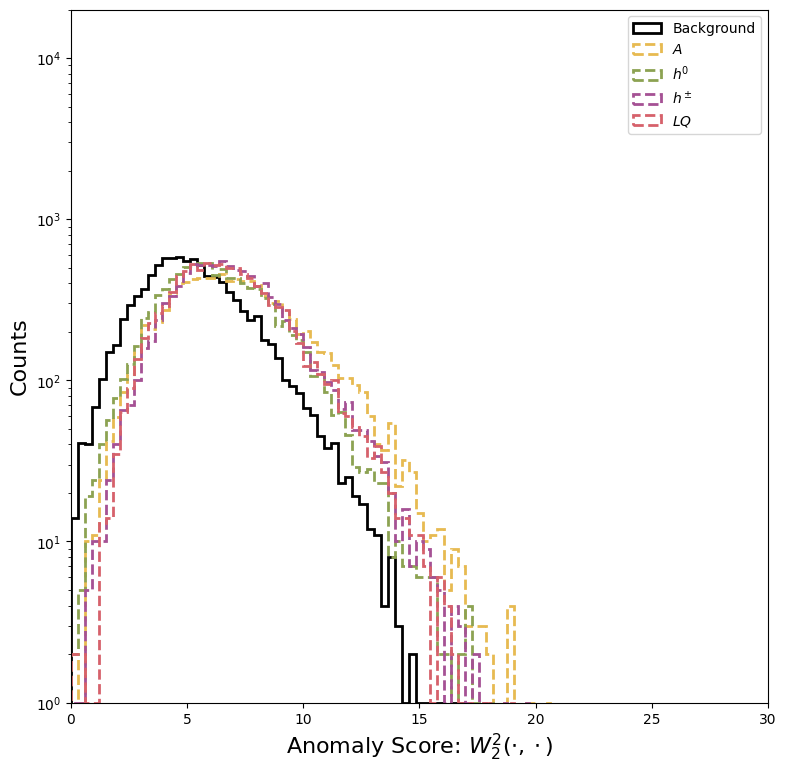

In [76]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 30)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 2e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Get AUCs, ROC, and SI curves

In [77]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

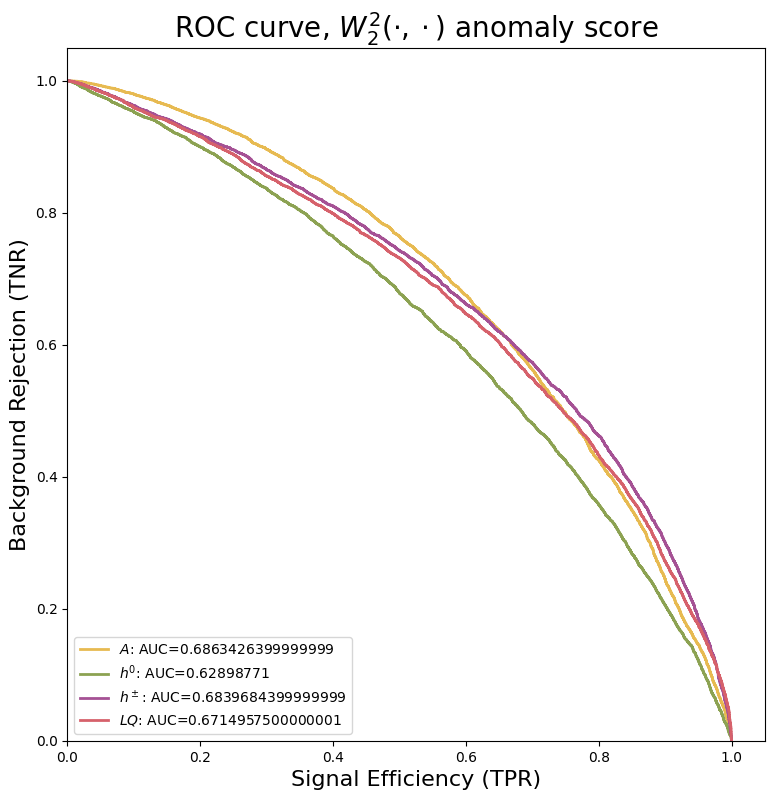

In [78]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

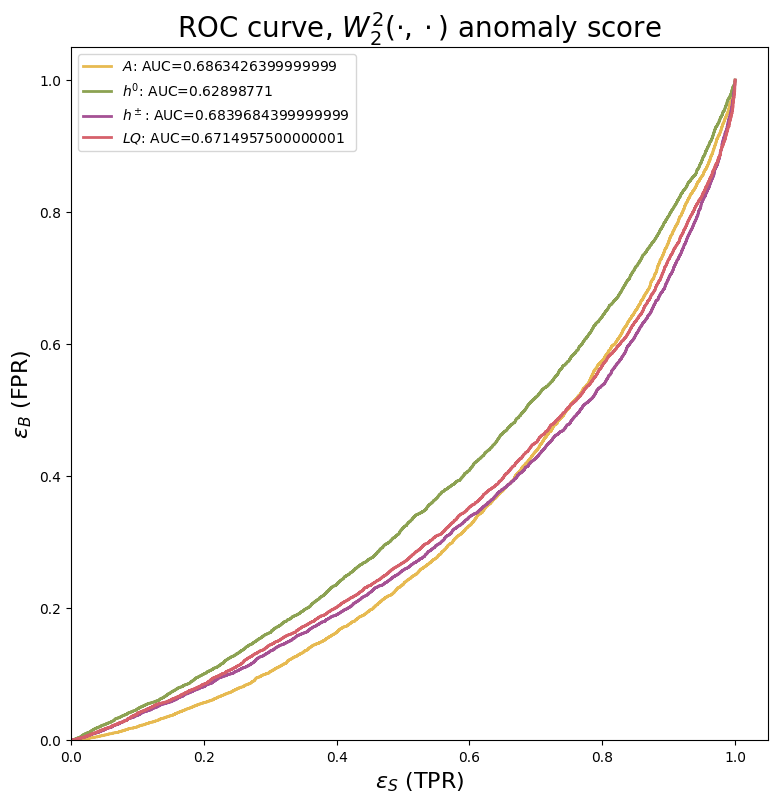

In [79]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

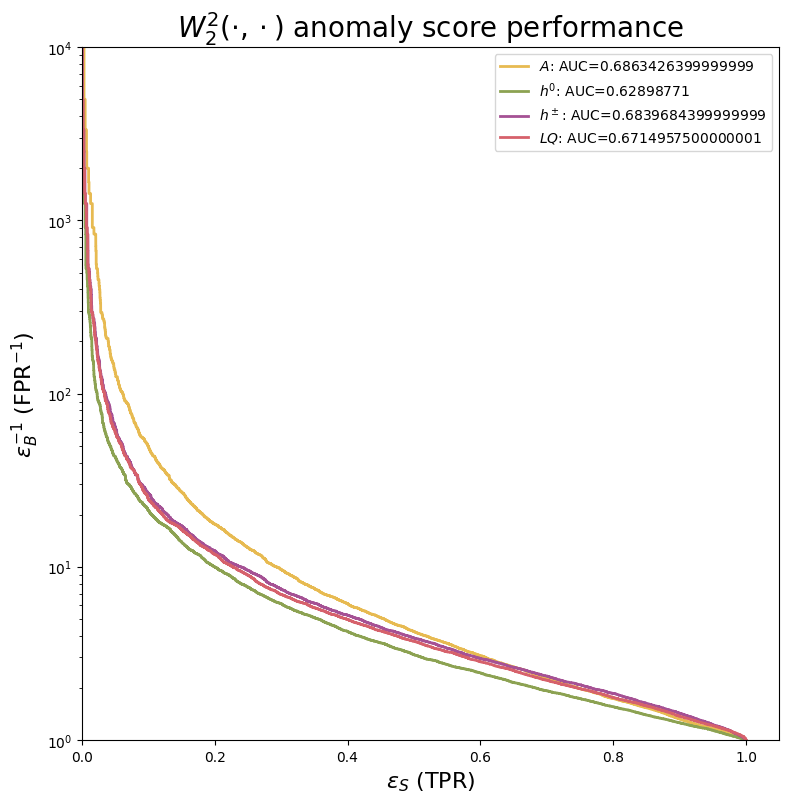

In [80]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 1e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

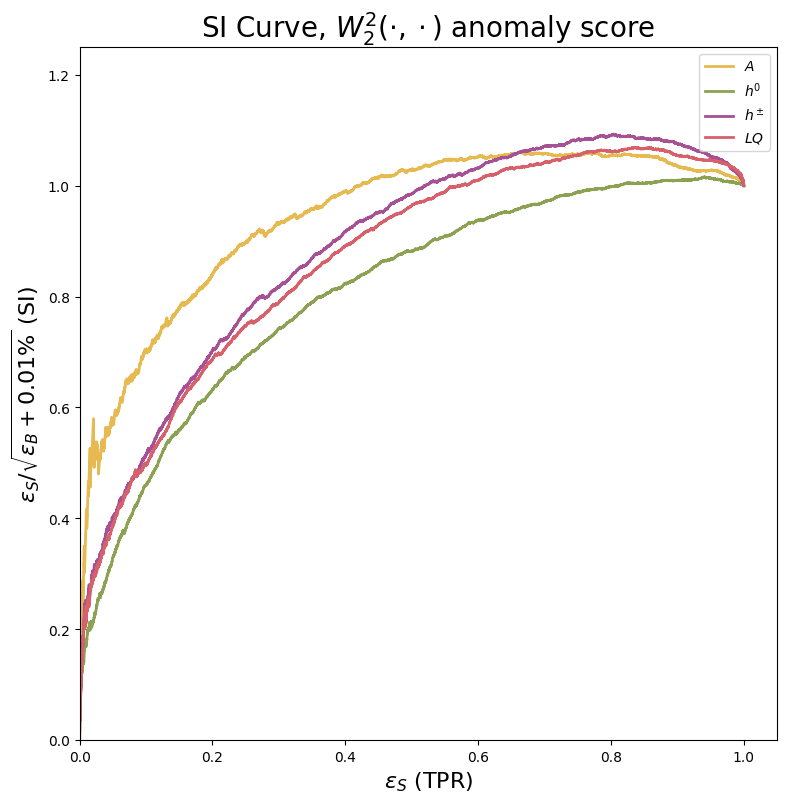

In [81]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.25)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [82]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0001 0.0008 0.0008 0.001 ]
[0.         0.01       0.08       0.05656854 0.07071068]


## Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [83]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [84]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.6863426399999999
     $h^0$: 0.62898771
   $h^\pm$: 0.6839684399999999
      $LQ$: 0.6714957500000001


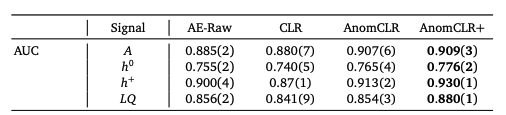

#### Inverse FPR (at TPR = 0.3):

In [85]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[1474, 2072, 1744, 1858]


In [86]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 9.652509652509652 (TPR=0.3)
     $h^0$: 6.134969325153374 (TPR=0.2998)
   $h^\pm$: 7.434944237918216 (TPR=0.3)
      $LQ$: 6.93000693000693 (TPR=0.3)


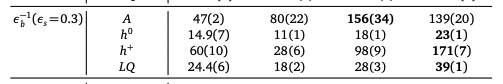

#### SI (at TPR = 0.3):

In [87]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.9316051410668053 (TPR=0.3)
     $h^0$: 0.7423430518444317 (TPR=0.2998)
   $h^\pm$: 0.8177089002010761 (TPR=0.3)
      $LQ$: 0.7894736842105263 (TPR=0.3)


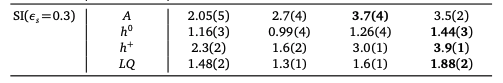